# Feature Selection

In [2]:
import import_ipynb
import utils
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_regression, f_classif
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from sklearn.feature_selection import SelectKBest
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
# préparation des données pour l'entrainement de 1992 - 2020
data_pop = utils.generate_df_from_files("./data_cleaned/population", "_population")
data_fertility = utils.generate_df_from_files("./data_cleaned/fertility", "_fertility")
data_child = utils.generate_df_from_files("./data_cleaned/child_mortality", "_child_mortality")
data_gdp = utils.generate_df_from_files("./data_cleaned/gdp_capita", "_gdp_capita")
data_climat = utils.generate_df_from_files("./", "climate_cleaned")[0]

#years = [1948, 1952, 1956, 1960, 1964, 1968, 1972, 1976, 1980, 1984, 1988, 1992, 1996, 2000, 2004, 2008, 2012, 2016, 2020] #19
years = [1992, 1996, 2000, 2004, 2008, 2012, 2016, 2020] # 8

# Labels des pays
countries = data_pop[11]["country"].values

data_medals = pd.read_csv("./second_part_countries_cleaned_no_normalized.csv")
data_medals = data_medals.T
data_medals.columns = years
data_medals['country'] = data_medals.index
data_medals.reset_index(drop=True, inplace=True)
data_medals = data_medals.drop(data_medals.index[-1])
# Réorganiser le DataFrame : passer les années en une seule colonne 'year'
data_medals_long = pd.melt(data_medals, id_vars=['country'], var_name='year', value_name='medals')

# Changer le nom de la colonne 2021(JO-2020) par 2020
data_pop[18] = data_pop[18].rename(columns={"2021(JO-2020)": "2020"})
data_fertility[18] = data_fertility[18].rename(columns={"2021(JO-2020)": "2020"})
data_child[18] = data_child[18].rename(columns={"2021(JO-2020)": "2020"})
data_gdp[18] = data_gdp[18].rename(columns={"2021(JO-2020)": "2020"})

# Préparation des données pour les classes en 3 classes pour le score de médailles
label_class_3 = pd.read_csv("labels_class_3_class.csv")
label_class_3 = label_class_3.T
label_class_3 .columns = years
label_class_3['country'] = label_class_3.index
label_class_3.reset_index(drop=True, inplace=True)
label_class_3 = label_class_3.drop(label_class_3.index[-1])

# Réorganiser le DataFrame : passer les années en une seule colonne 'year'
label_class_3_long = pd.melt(label_class_3, id_vars=['country'], var_name='year', value_name='class')


# Initialiser une liste pour stocker toutes les années de données combinées
final_data = []

# Parcourir chaque année pour combiner les données
for i, year in enumerate(years):

    j = i + 11 # 1992 est le 11ème élément de la liste des années jusqu'à 2020

    # Vérifier si l'année existe dans les colonnes des DataFrames
    year_str = str(year)  # Utiliser le format chaîne pour être sûr
    
    if year_str not in data_pop[j].columns:
        print(f"⚠️ L'année {year} n'existe pas dans le DataFrame data_pop[{j}]. Colonnes disponibles : {data_pop[j].columns}")
        continue

    # Récupérer les colonnes pertinentes pour chaque dataset
    pop_df = data_pop[j][["country", year_str]].rename(columns={year_str: "pop"})
    fertility_df = data_fertility[j][["country", year_str]].rename(columns={year_str: "fertility"})
    child_df = data_child[j][["country", year_str]].rename(columns={year_str: "child"})
    gdp_df = data_gdp[j][["country", year_str]].rename(columns={year_str: "gdp"})

    # Joindre les DataFrames sur "country"
    merged_df = pd.DataFrame({"country": countries})
    merged_df = merged_df.merge(pop_df, on="country", how="left")
    merged_df = merged_df.merge(fertility_df, on="country", how="left")
    merged_df = merged_df.merge(child_df, on="country", how="left")
    merged_df = merged_df.merge(gdp_df, on="country", how="left")

    # Ajouter l'année dans le DataFrame
    merged_df["year"] = year

    # Réordonner les colonnes pour mettre "year" avant "country"
    cols = ["year"] + [col for col in merged_df.columns if col != "year"]
    merged_df = merged_df[cols]

    # Ajouter les données climatiques (fixes pour chaque pays)
    merged_df = merged_df.merge(data_climat, on="country", how="left")

    # Ajouter au DataFrame final
    final_data.append(merged_df)

# Concaténer toutes les années en un seul DataFrame
final_df = pd.concat(final_data, ignore_index=True)

# Rajouter les médailles
final_df["score"] = data_medals_long["medals"]

# Rajouter les classes pour score
final_df["class"] = label_class_3_long["class"]

# Remplir les valeurs manquantes par 0 pour éviter les NaN dans t-SNE
final_df = final_df.fillna(0)

# Afficher un aperçu
print(final_df.head())

# Créer un array numpy pour t-SNE avec les colonnes pertinentes
X = final_df[['pop', 'fertility', 'child', 'gdp', 'Avg_Temperature', 'Avg_Precipitation', 'Avg_Seasonality', 'Avg_Aridity']].values
y_regression = final_df['score'].values  # Score de médailles pour régression
y_classification = final_df['class'].values  # Score de médailles pour classification
countries_name = final_df['country'].values  # Noms des pays pour annotations

   year    country       pop  fertility     child       gdp  Avg_Temperature  \
0  1992    Albania  0.002779   0.259972  0.102065  0.025418         0.550000   
1  1992    Algeria  0.022542   0.449794  0.133229  0.064224         0.500000   
2  1992     Angola  0.010508   0.844567  0.707830  0.030393         0.516667   
3  1992  Argentina  0.028559   0.273728  0.069277  0.137042         0.423077   
4  1992    Armenia  0.003025   0.206327  0.126412  0.024514         0.480000   

   Avg_Precipitation  Avg_Seasonality  Avg_Aridity  score  class  
0           0.600000         0.475000     0.450000    1.0      0  
1           0.360000         0.240000     0.640000   14.0      0  
2           0.483333         0.333333     0.500000    1.0      0  
3           0.469231         0.338462     0.453846   12.0      0  
4           0.460000         0.420000     0.440000    0.0      0  


## EDA (Analyse exploratoire des données)

In [5]:
# Dataframe pour l'EDA
df_EDA = final_df.select_dtypes(include=['int64', 'float64'])
df_EDA = df_EDA.drop(['class'], axis=1)

## Décomposition en valeurs singulières

Text(0, 0.5, '$\\log_{10}$ Valeurs singulières \n (normalisées par rapport à la plus grande valeur)')

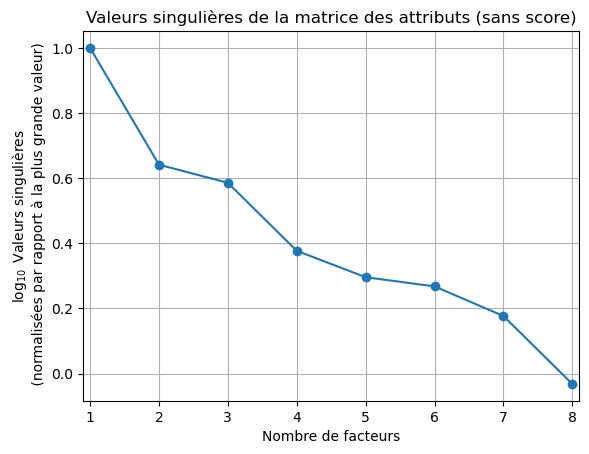

In [171]:
from matplotlib import pyplot as plt
import numpy as np

U, S, Vt = np.linalg.svd(X)

log_singular_values = np.log(S)

s = log_singular_values / np.max(log_singular_values)

# plot values
plt.plot(range(1, len(s) + 1), s, marker='o')
plt.grid(True)
plt.xlim(0.9, 8.1)
plt.title("Valeurs singulières de la matrice des attributs (sans score)")
plt.xlabel("Nombre de facteurs")
plt.ylabel('$\\log_{10}$ Valeurs singulières \n (normalisées par rapport à la plus grande valeur)')

## Matrice de corrélation

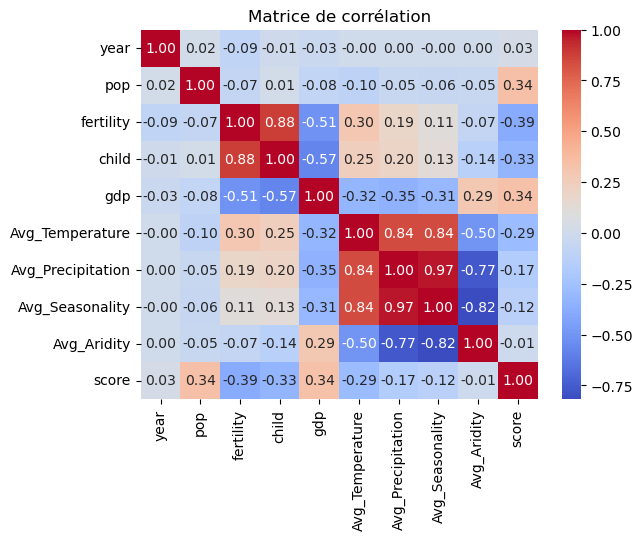

In [67]:
# Matrice de corrélation
correlation_matrix = df_EDA.corr()

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matrice de corrélation")
plt.show()

## Pair-plots

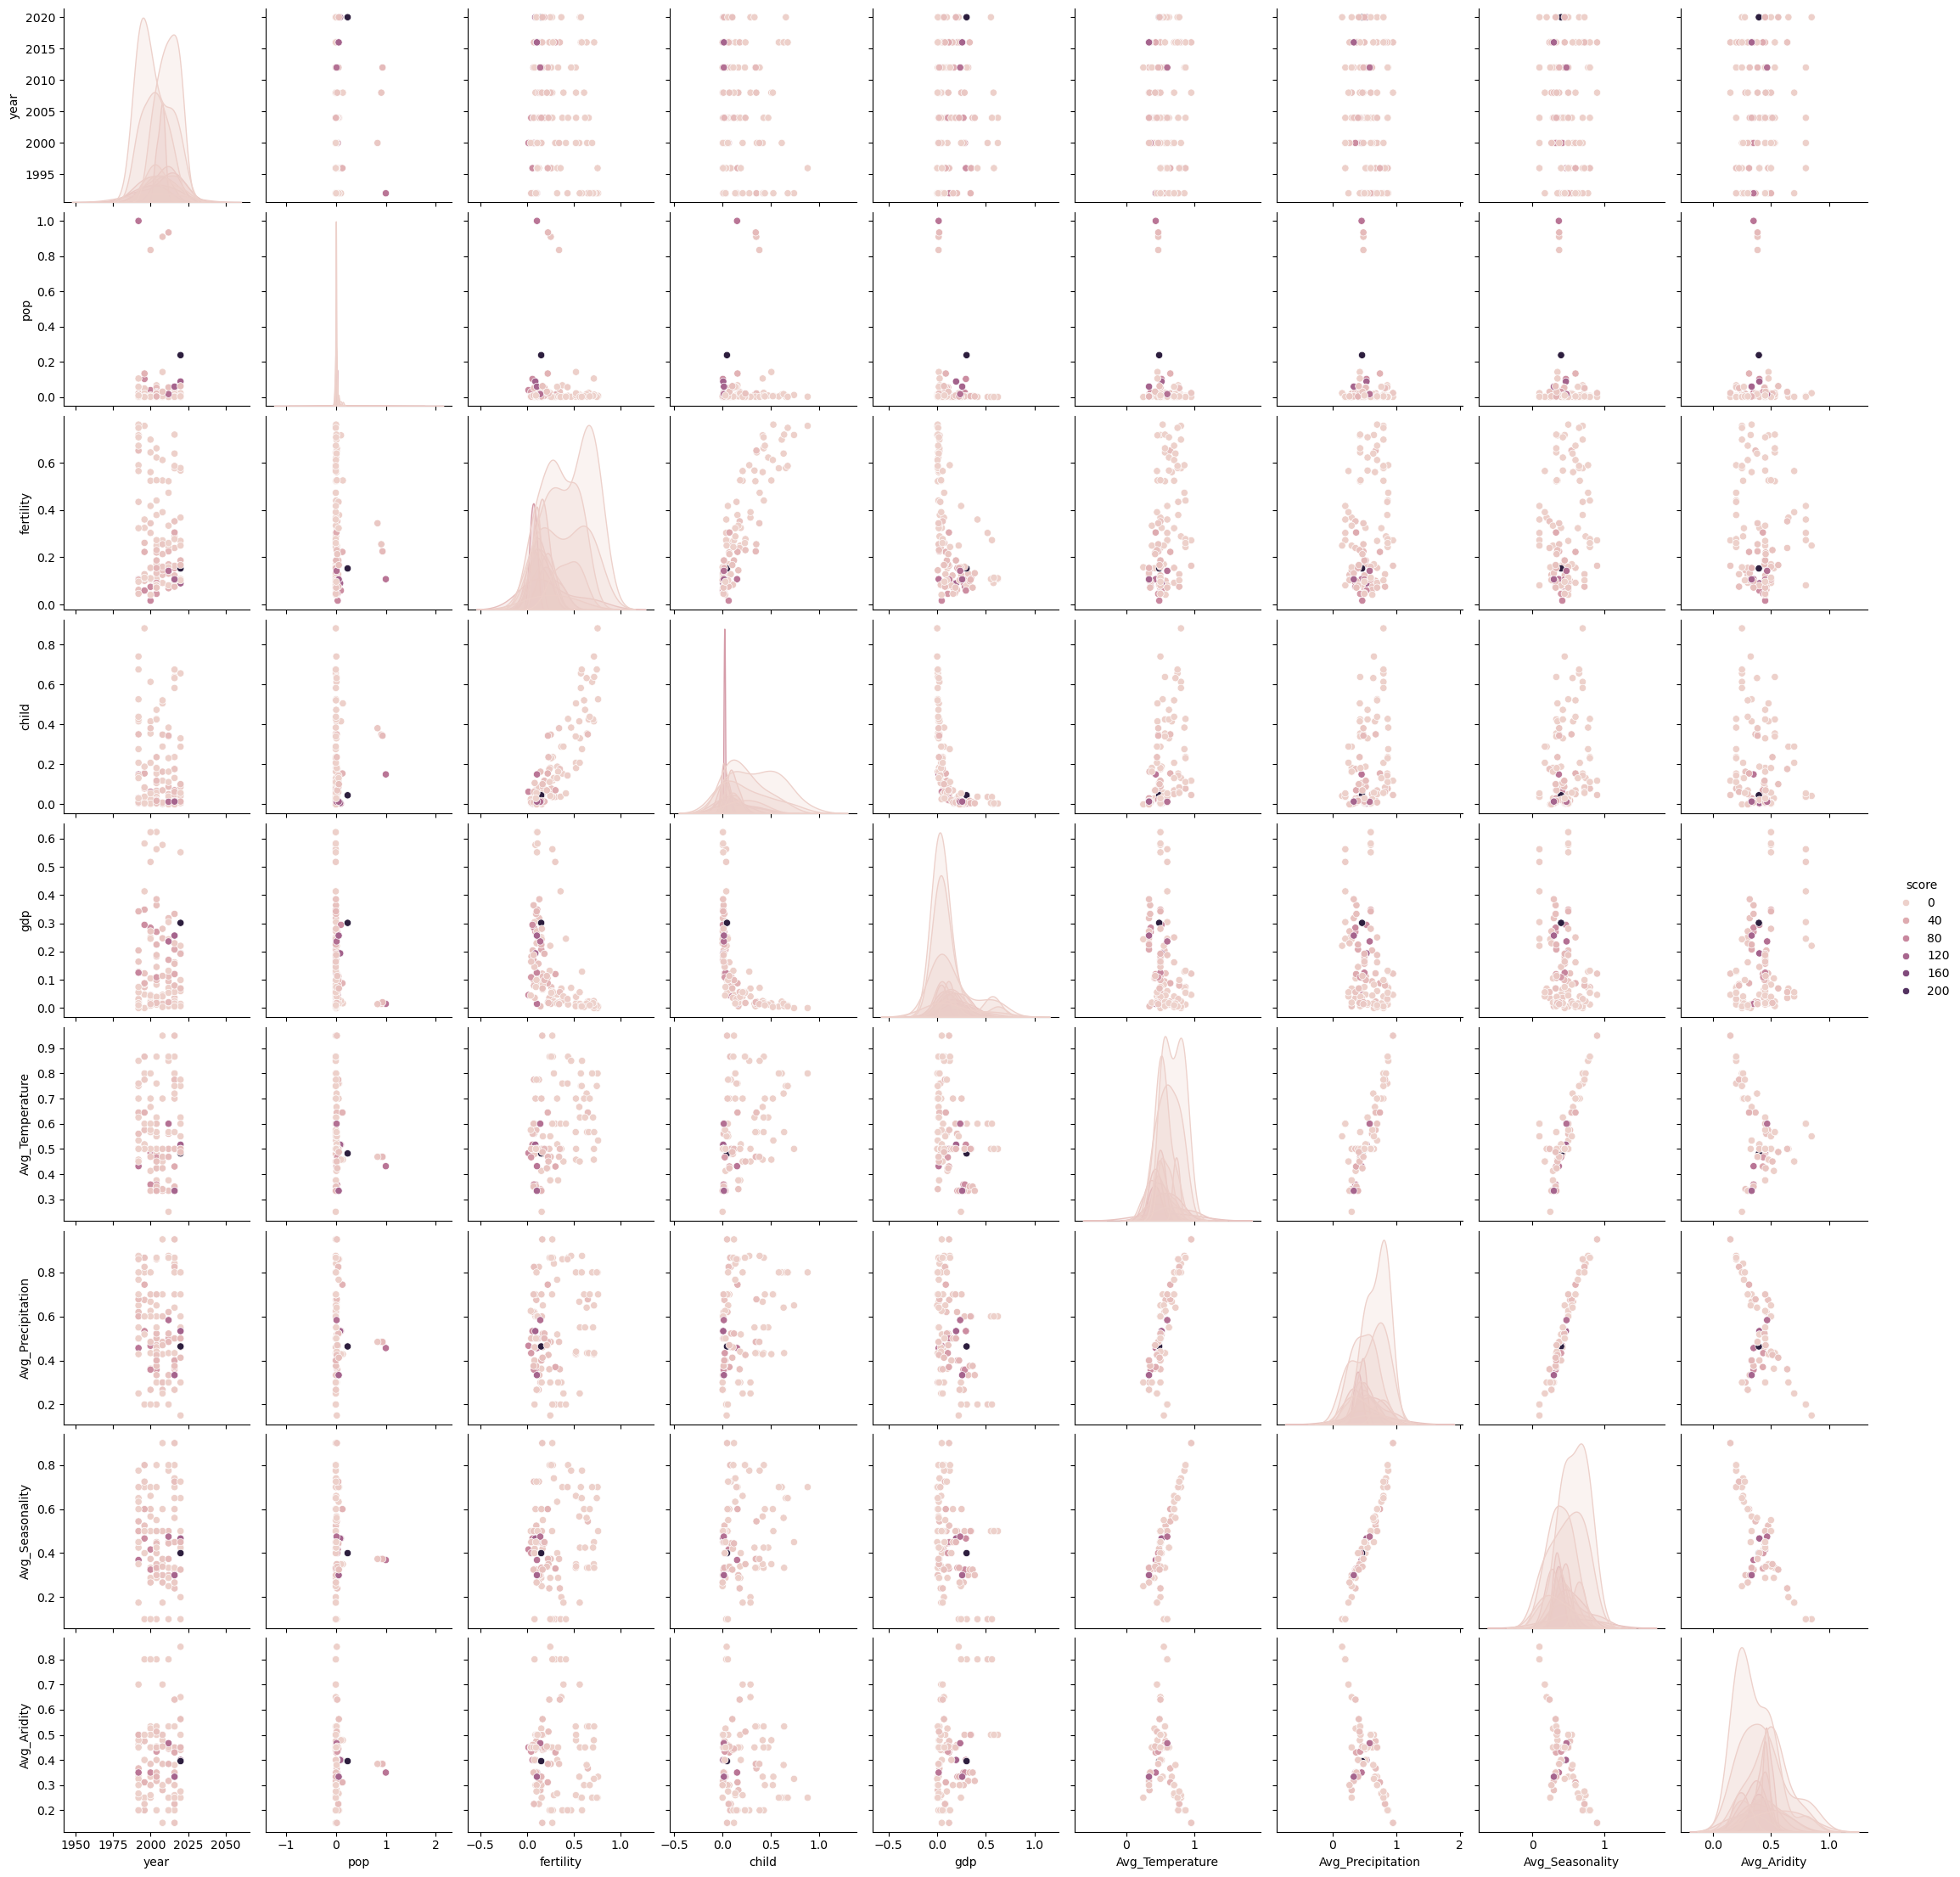

In [70]:
df_sample = df_EDA.sample(frac=0.1, random_state=42)

# Pairplot sur l'échantillon
sns.pairplot(df_sample, hue="score")

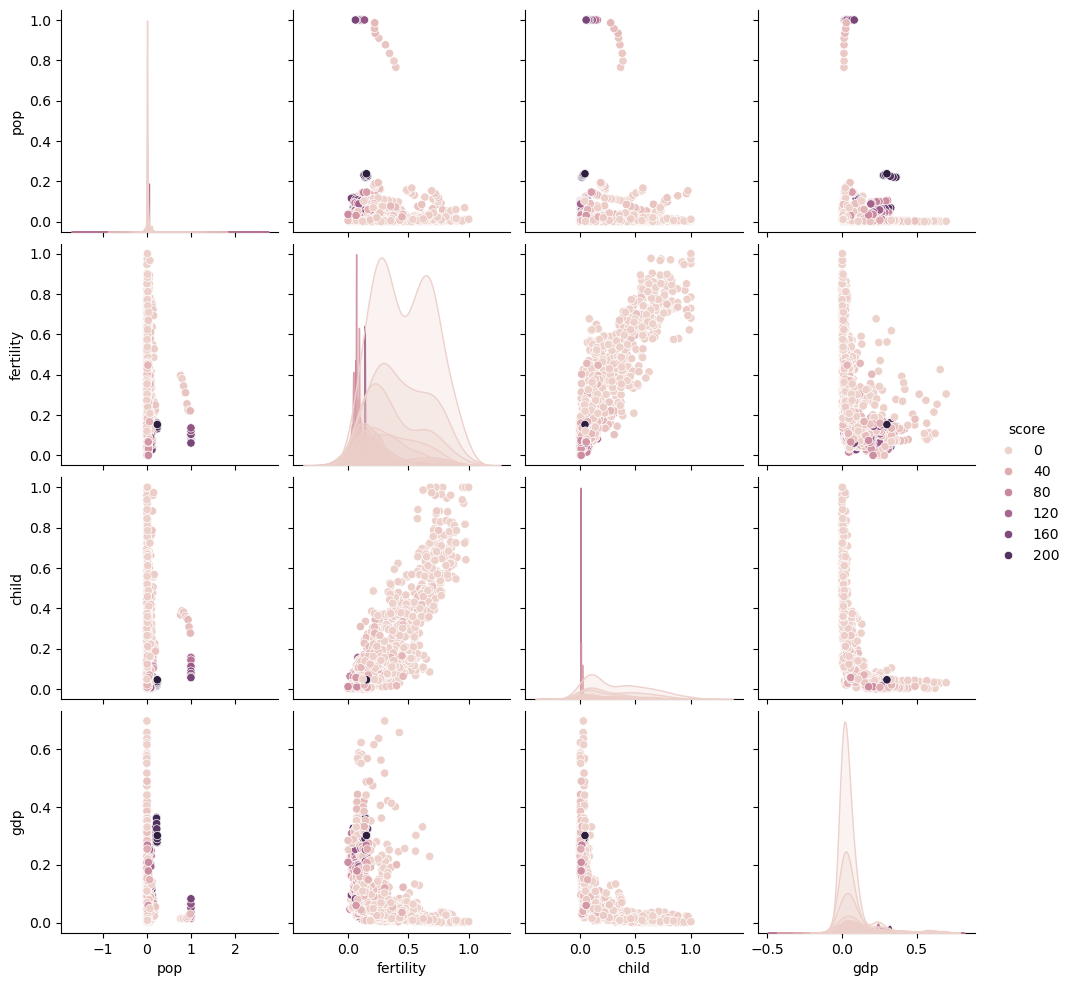

In [79]:
# Sélection de colonnes spécifiques
cols = ['pop', 'fertility', 'child', 'gdp', 'score']
sns.pairplot(df_EDA[cols], hue="score")


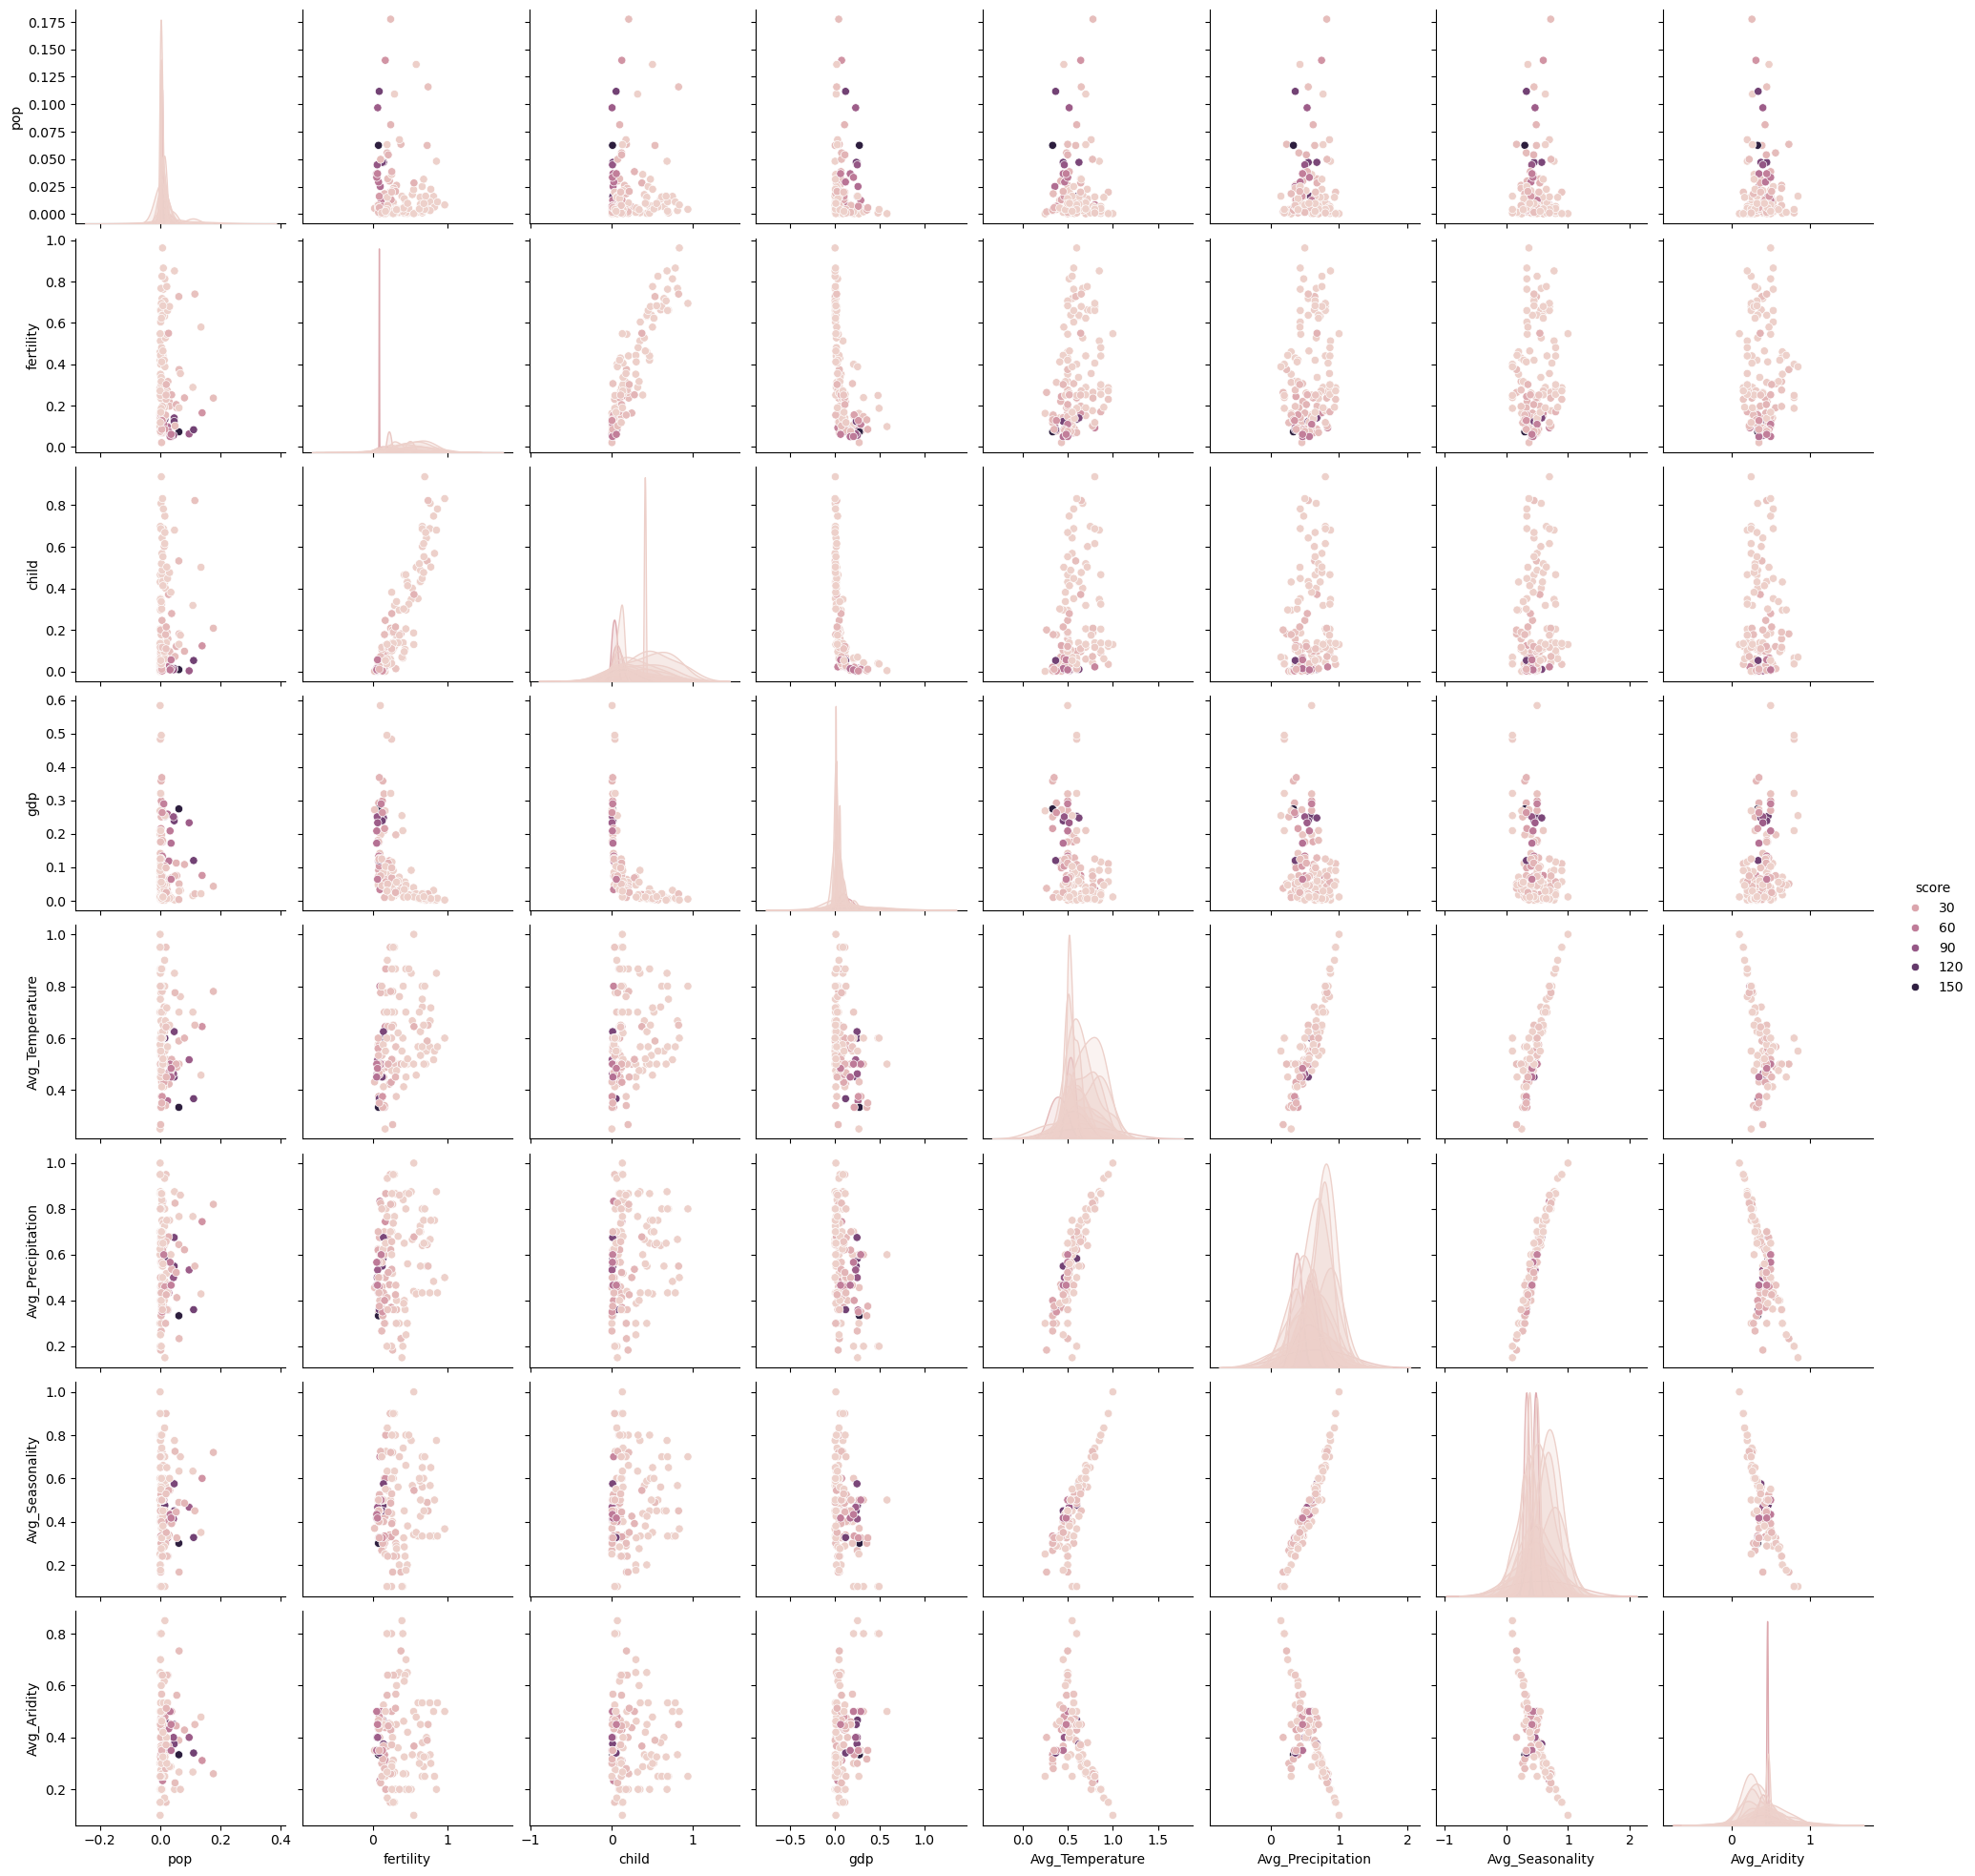

In [85]:
cols = ['pop', 'fertility', 'child', 'gdp', 'Avg_Temperature', 'Avg_Precipitation', 'Avg_Seasonality', 'Avg_Aridity', 'score']
df_mean_by_country = df_mean_by_country.reset_index()

# Maintenant, vous pouvez filtrer en fonction de 'country'
df_mean_by_country_wo_uscnin = df_mean_by_country[~df_mean_by_country['country'].isin(['USA', 'China', 'India'])]

# sns.pairplot(df_mean_by_country[cols], hue="score")
sns.pairplot(df_mean_by_country_wo_uscnin[cols], hue="score")

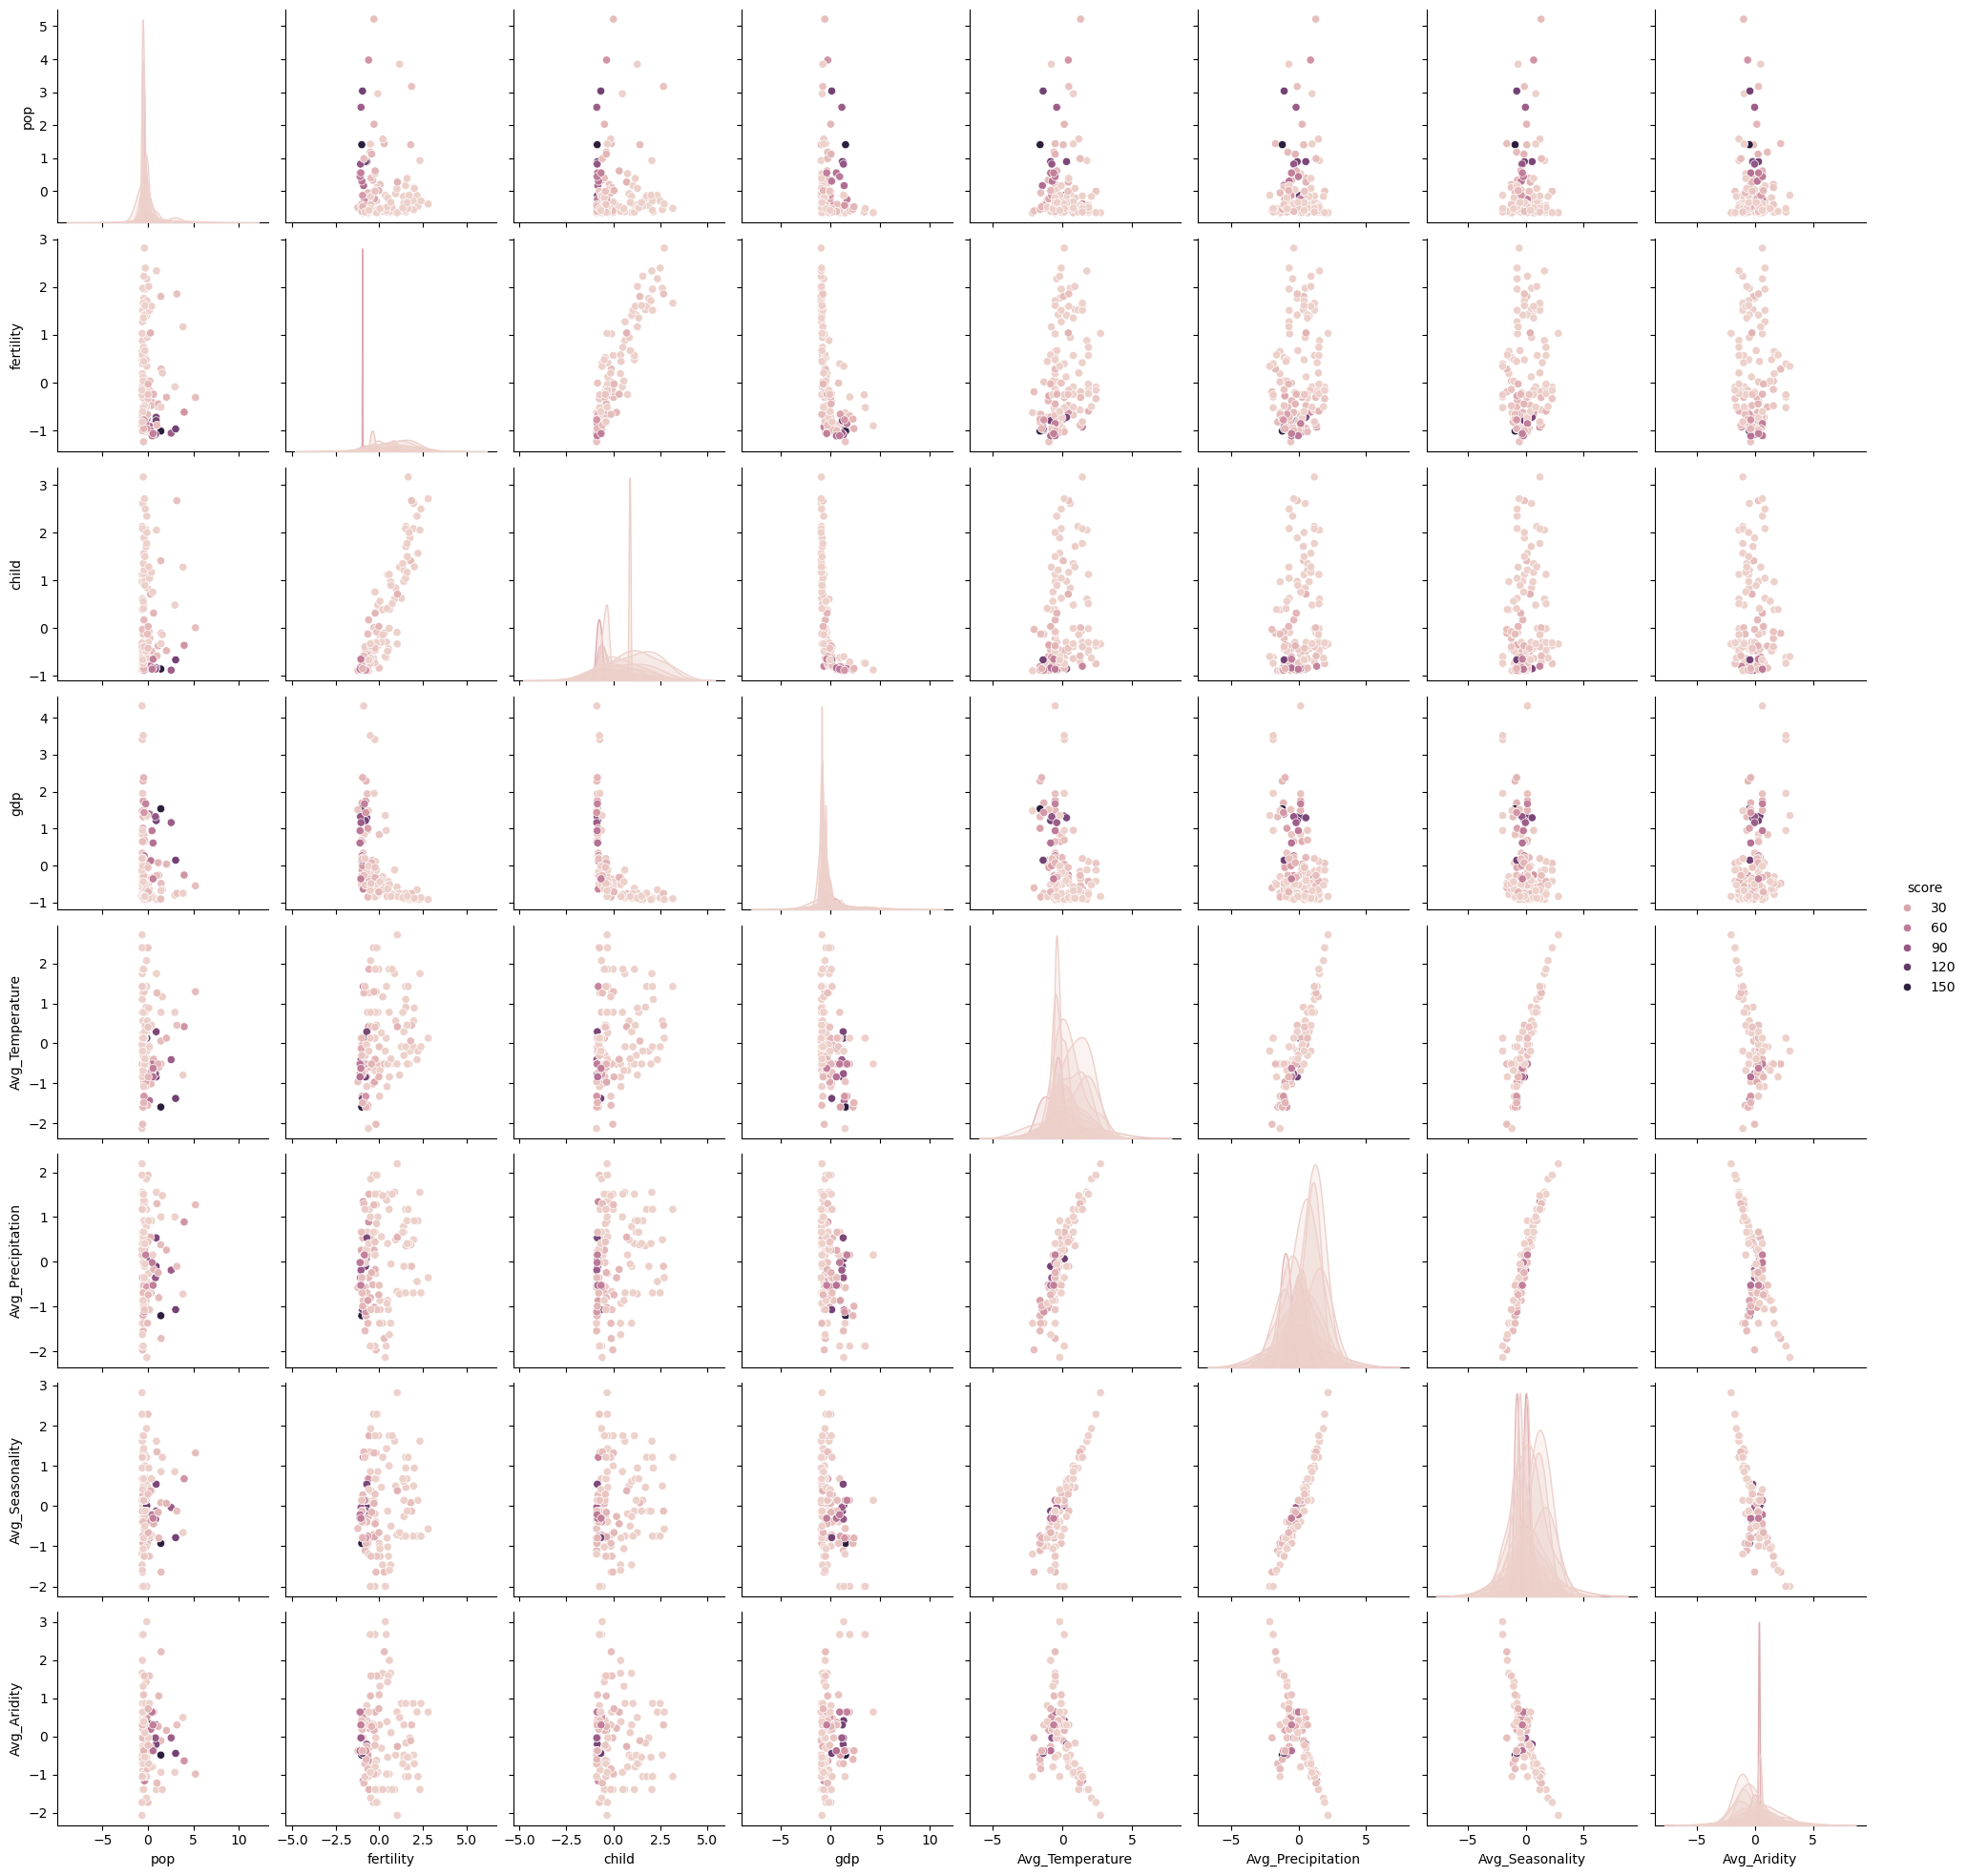

In [86]:
from sklearn.preprocessing import StandardScaler

# Exclure les États-Unis et la Chine
df_wo_uscnin = df_mean_by_country_wo_uscnin.copy()

# Normaliser les colonnes sélectionnées
scaler = StandardScaler()
df_scaled = df_wo_uscnin.copy()

columns_to_scale = ['pop', 'fertility', 'child', 'gdp', 'Avg_Temperature', 'Avg_Precipitation', 'Avg_Seasonality', 'Avg_Aridity']
df_scaled[columns_to_scale] = scaler.fit_transform(df_wo_uscnin[columns_to_scale])

# Afficher le pairplot des données normalisées
sns.pairplot(df_scaled, hue="score")

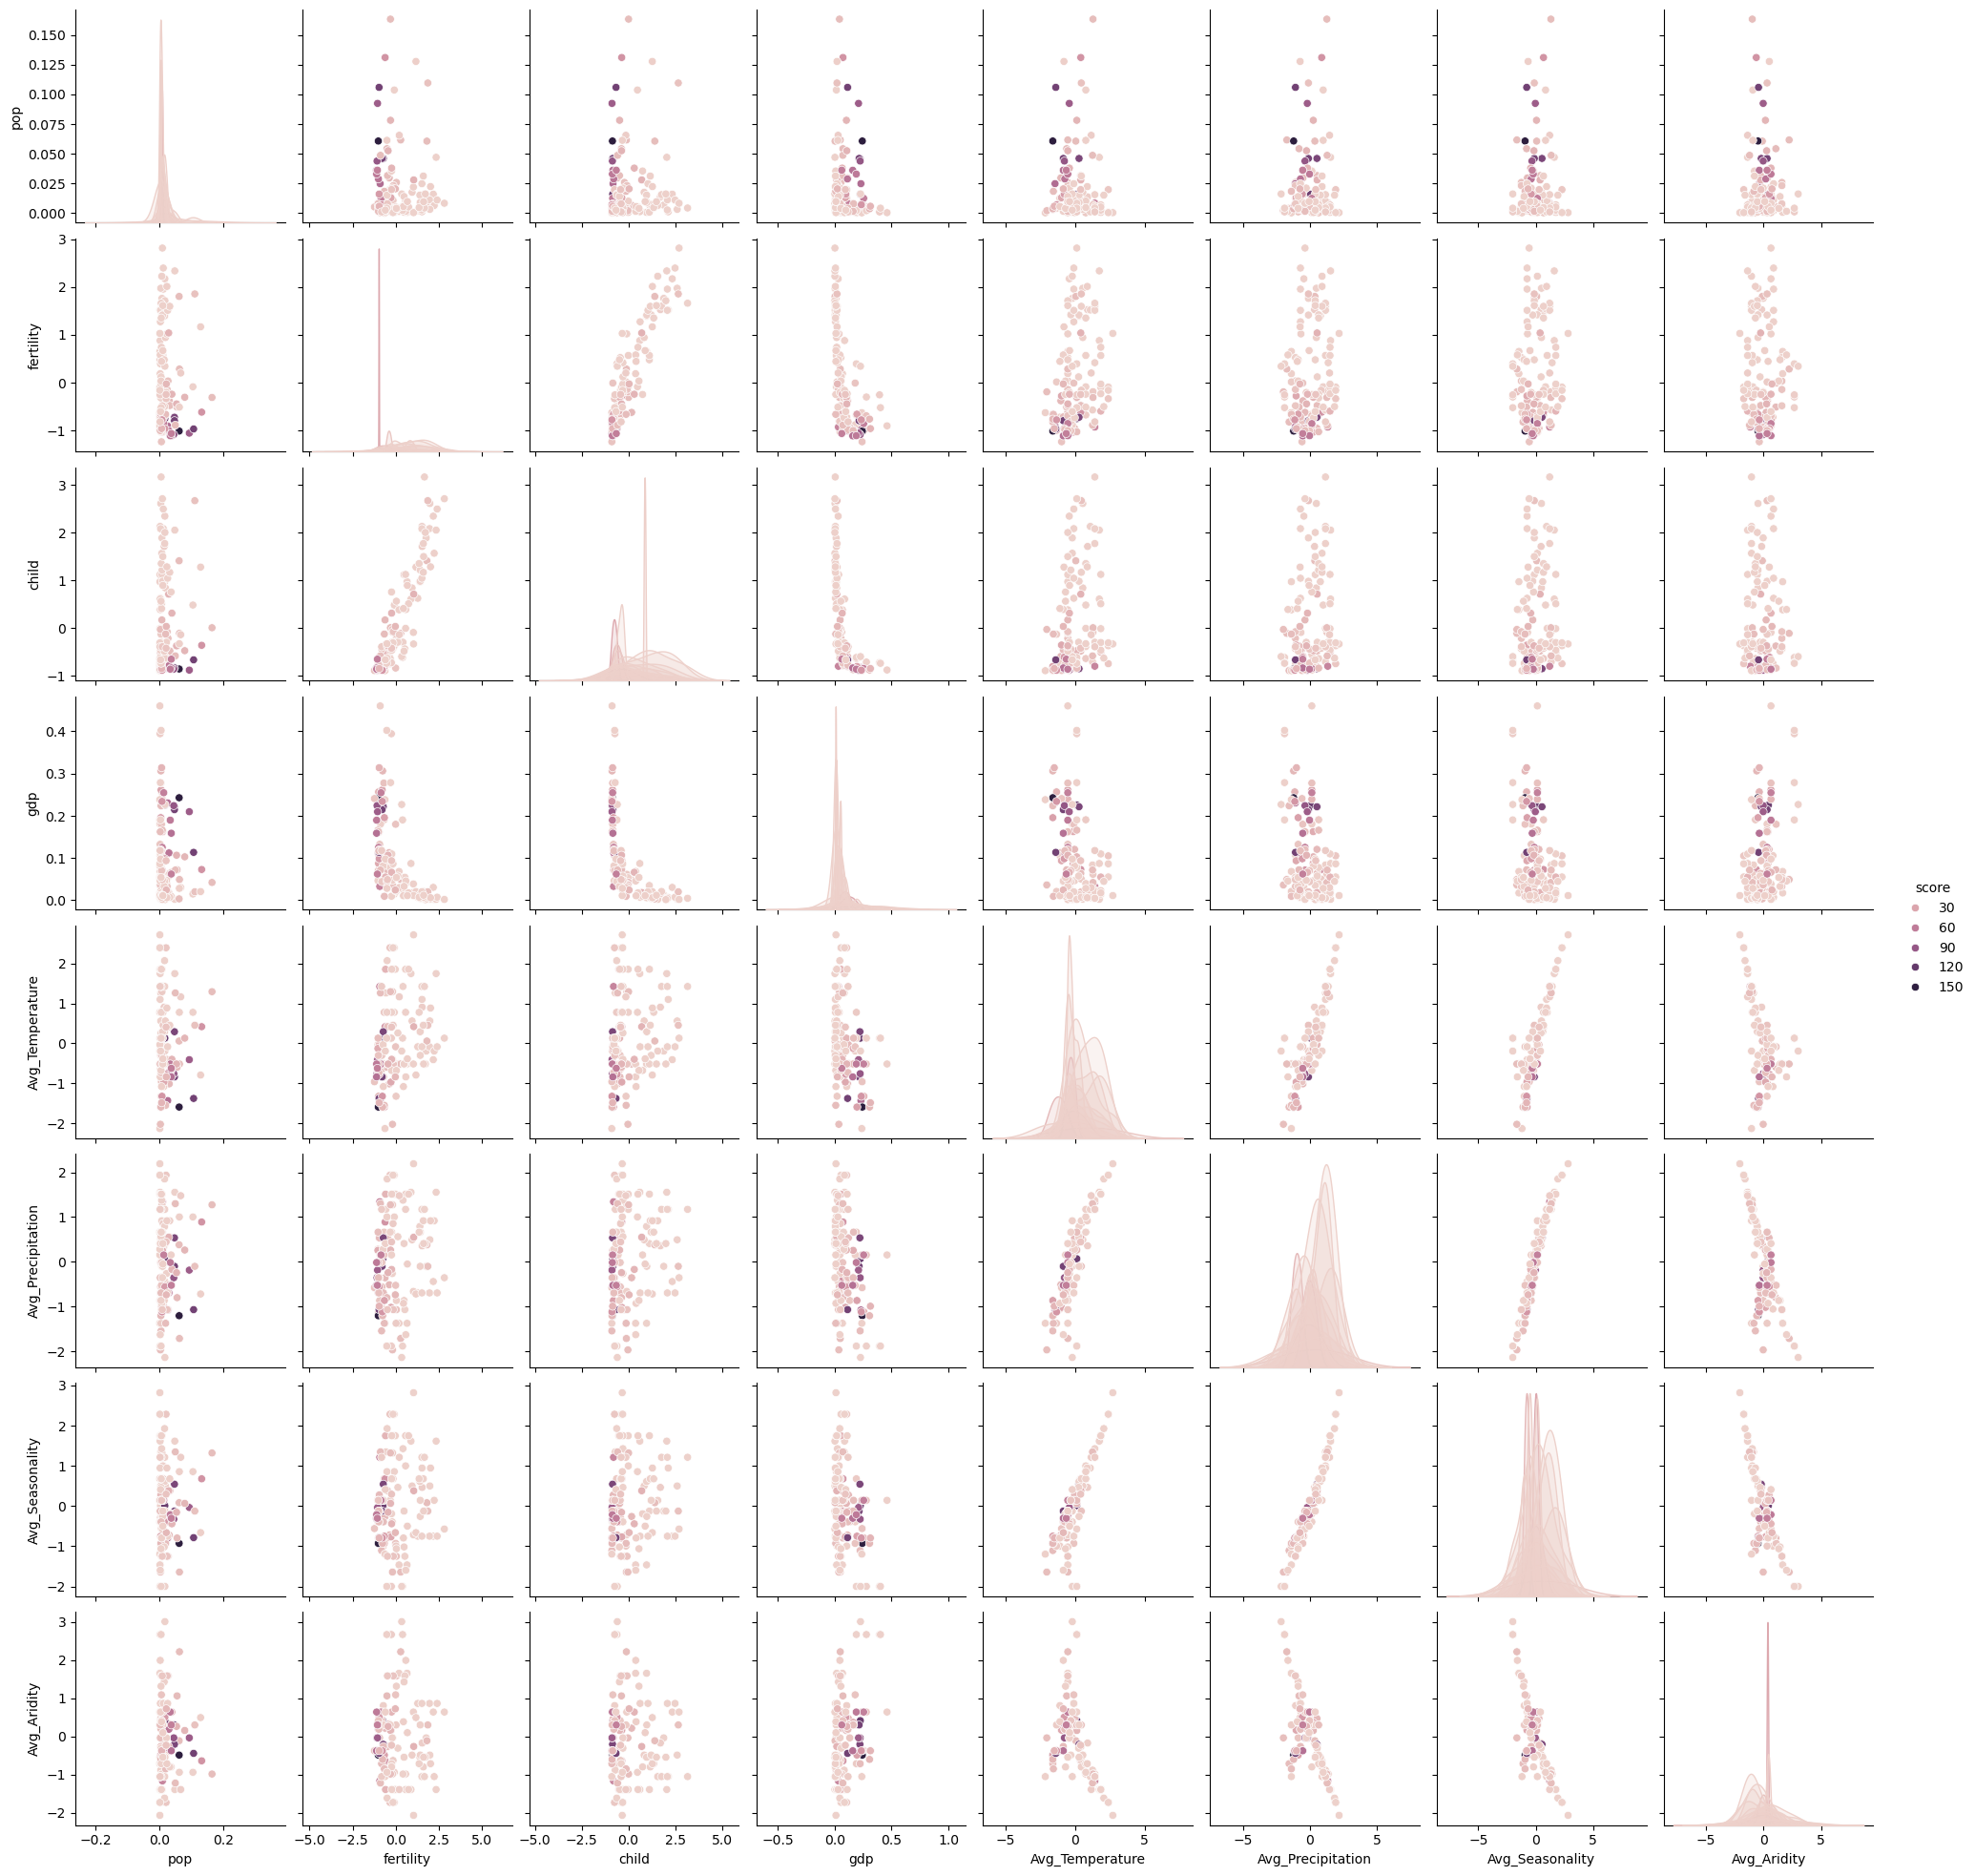

In [87]:
# Créer une copie du DataFrame
df_transformed = df_wo_uscnin.copy()

# Appliquer la transformation logarithmique à la population et au PIB
df_transformed[['pop', 'gdp']] = df_wo_uscnin[['pop', 'gdp']].apply(np.log1p)

# Appliquer la normalisation sur les autres colonnes
scaler = StandardScaler()
columns_to_scale = ['fertility', 'child', 'Avg_Temperature', 'Avg_Precipitation', 'Avg_Seasonality', 'Avg_Aridity']
df_transformed[columns_to_scale] = scaler.fit_transform(df_wo_uscnin[columns_to_scale])

# Afficher le pairplot des données transformées
sns.pairplot(df_transformed, hue="score")

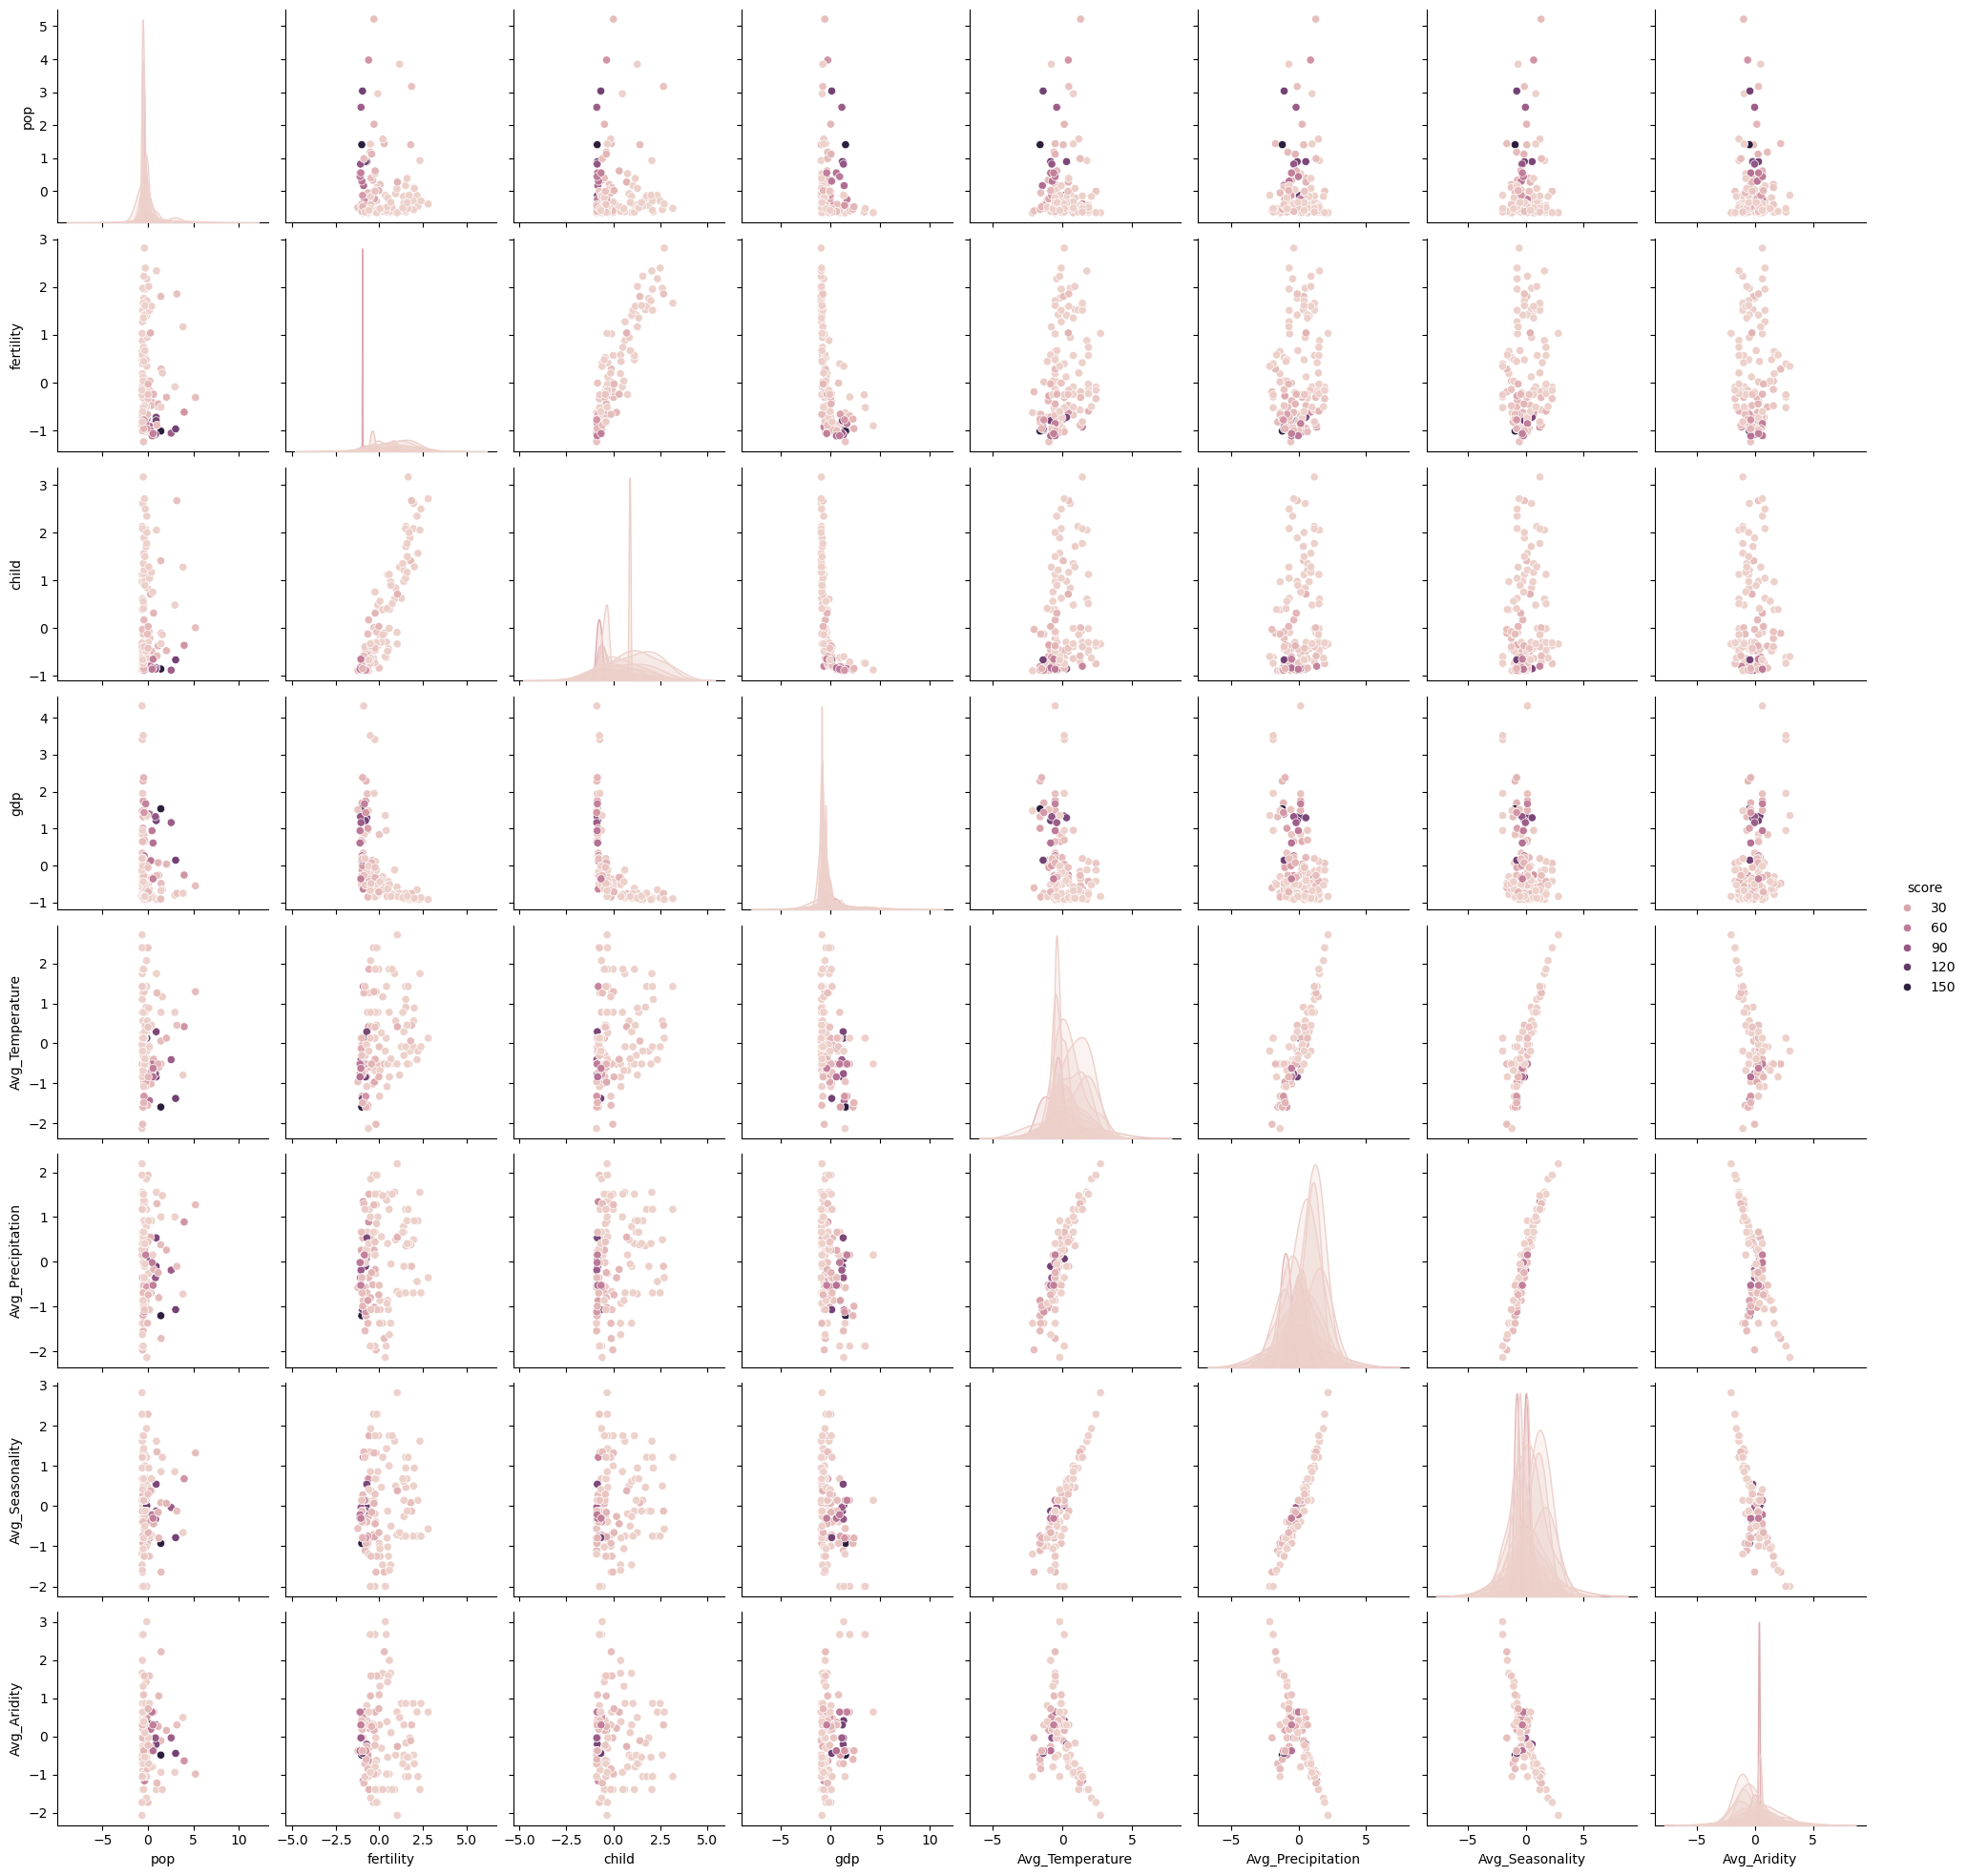

In [88]:
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Créer une copie du DataFrame
df_standardized = df_wo_uscnin.copy()

# Appliquer la standardisation (StandardScaler) sur les colonnes sélectionnées
columns_to_standardize = ['pop', 'fertility', 'child', 'gdp', 'Avg_Temperature', 'Avg_Precipitation', 'Avg_Seasonality', 'Avg_Aridity']
df_standardized[columns_to_standardize] = StandardScaler().fit_transform(df_wo_uscnin[columns_to_standardize])

# Afficher le pairplot des données standardisées
sns.pairplot(df_standardized, hue="score")

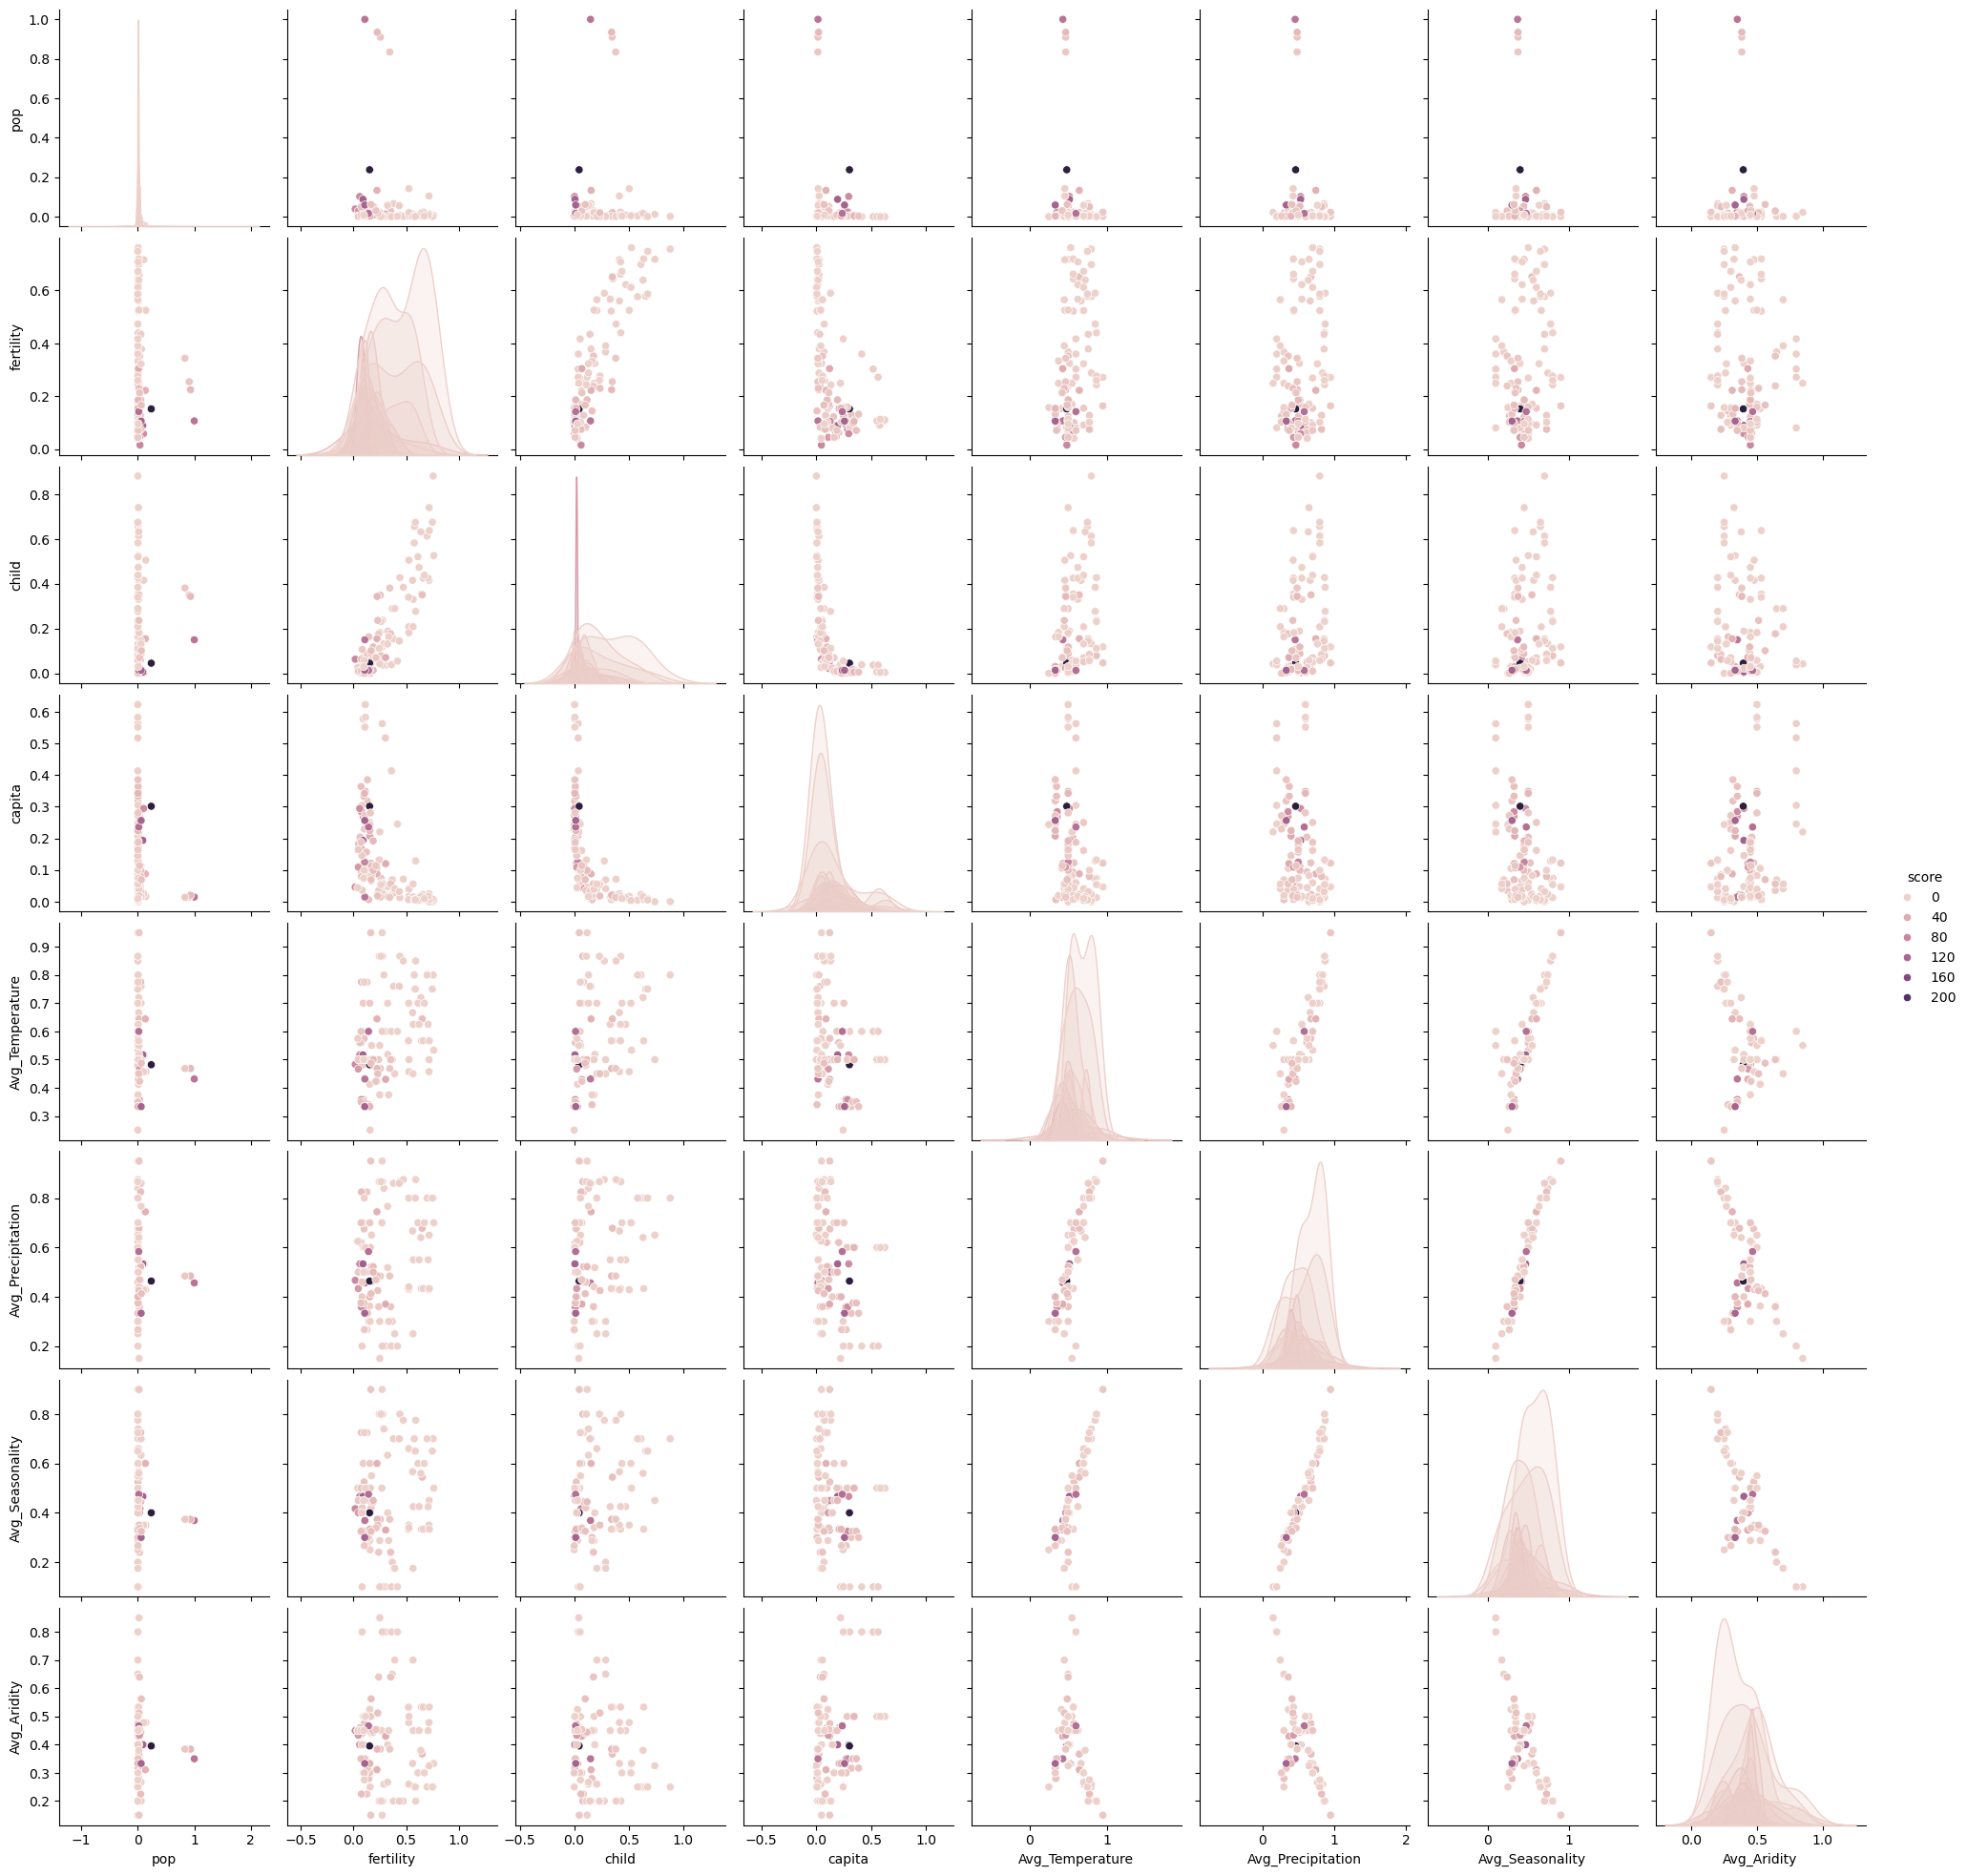

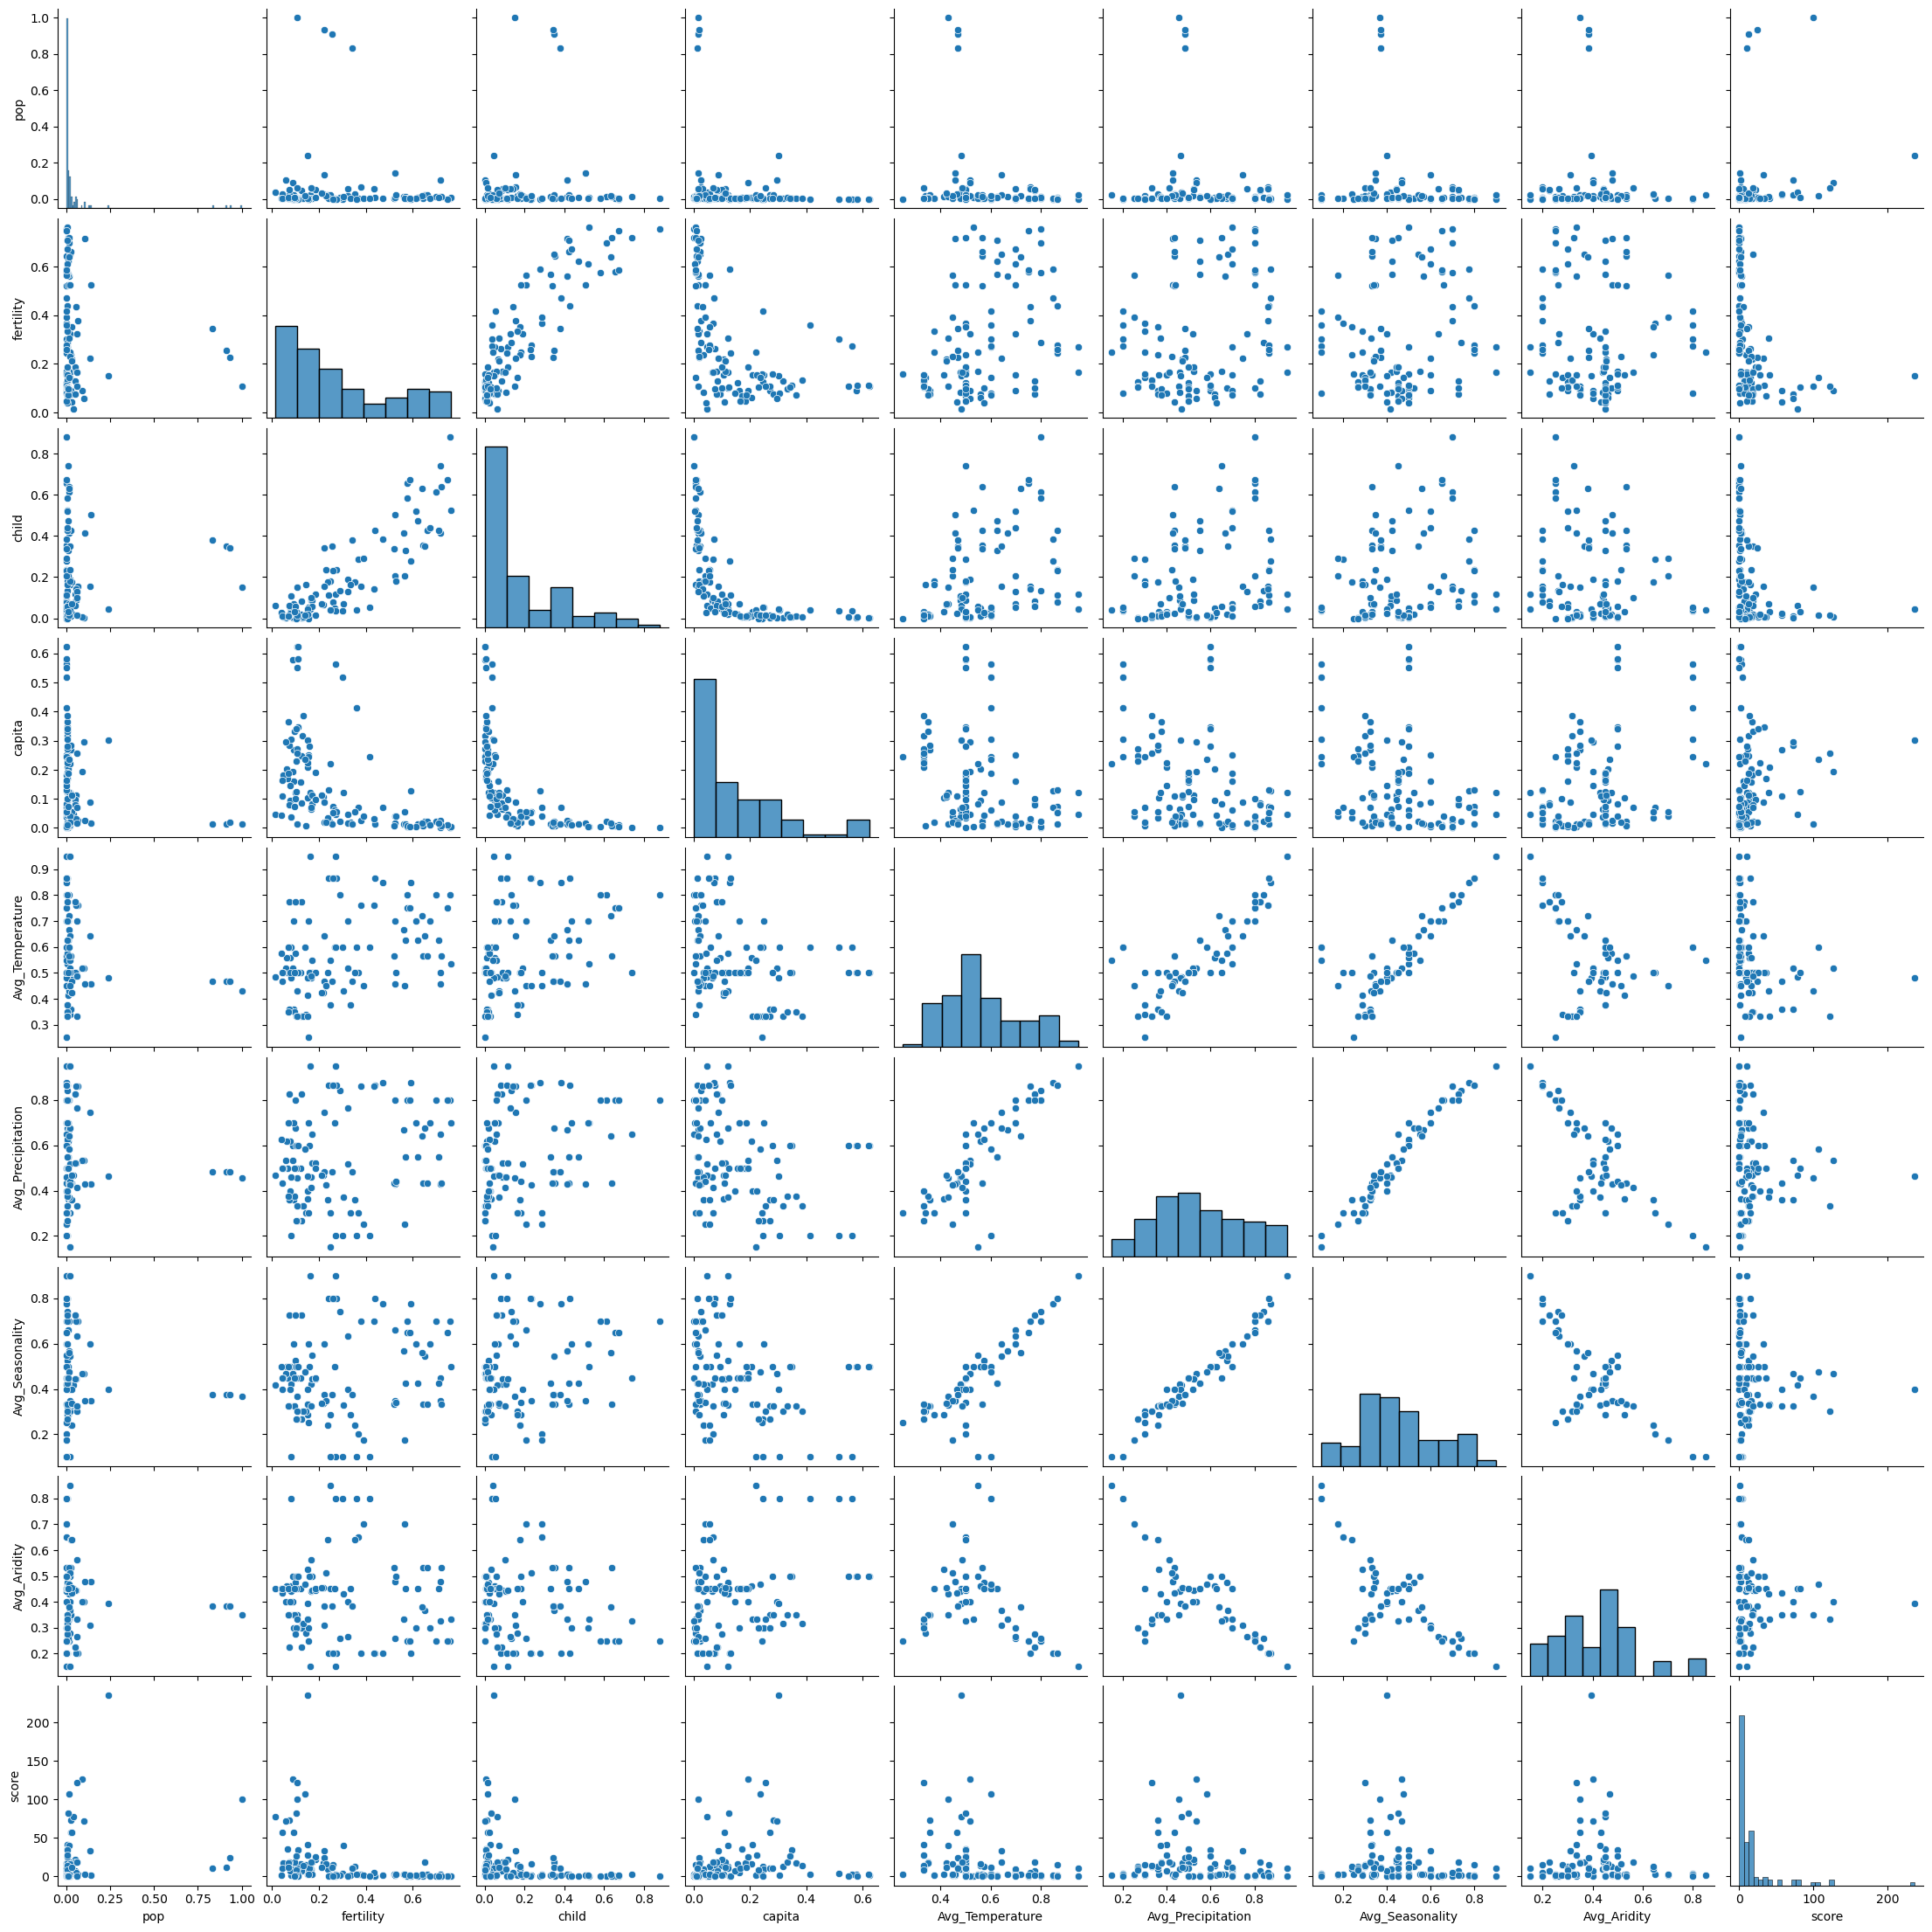

In [62]:
# df_sample = df_EDA.sample(n=200,    random_state=42)
df_sample = df_EDA.sample(frac=0.1, random_state=42)

# Pairplot sur l'échantillon
sns.pairplot(df_sample.drop(columns='year', axis=1), hue="score")
sns.pairplot(df_sample.drop(columns='year', axis=1))

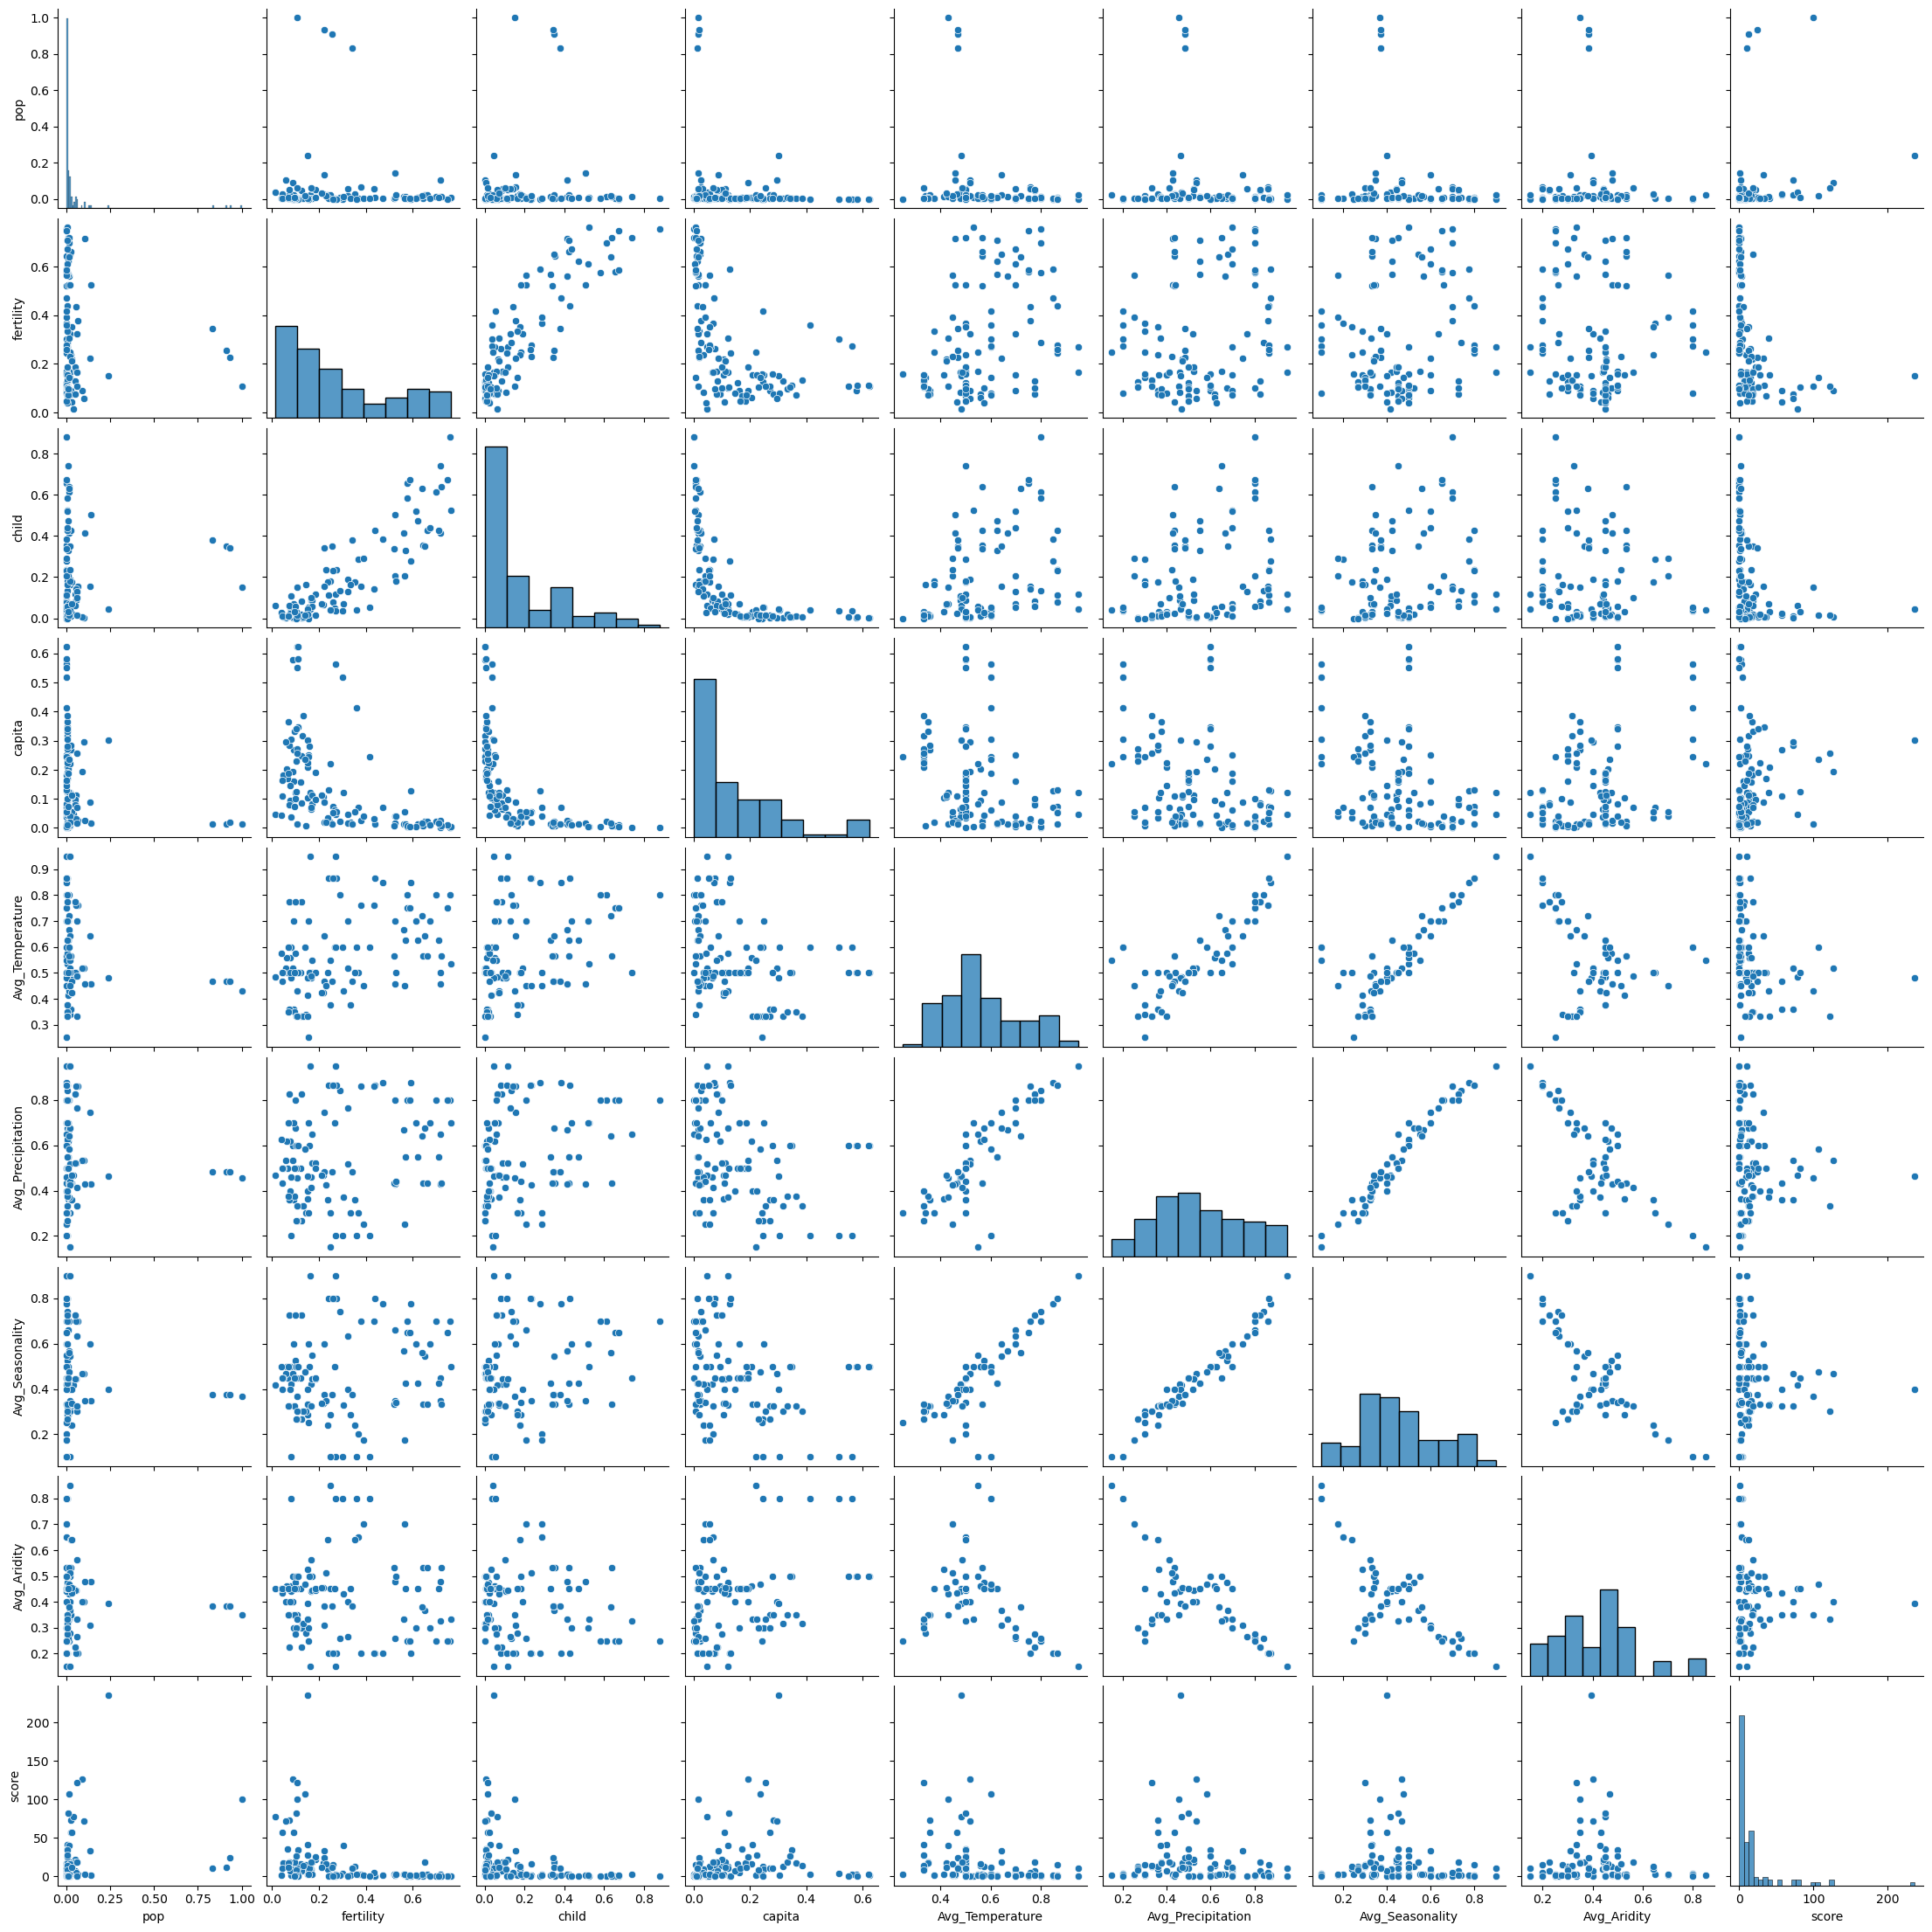

In [59]:
# Garder uniquement les variables pertinentes (par exemple, |corr| > 0.1)
relevant_cols = correlation_matrix.columns[(correlation_matrix.abs() > 0.1).any()]
df_sample_wo_year = final_df.drop(columns='year', axis=1)
sns.pairplot(df_sample_wo_year.sample(frac=0.1, random_state=42)[relevant_cols])

## Données moyennées

In [7]:
# Nombre de pays dans votre dataset
num_countries = 143  

# Étape 1 : Extraire les noms uniques des pays à partir des premières 143 lignes
country_names = final_df.loc[:num_countries - 1, 'country'].tolist()

# Étape 2 : Ajouter une colonne `country_id` et mapper les noms des pays
df_EDA['country_id'] = df_EDA.index % num_countries  # ID numérique des pays
df_EDA['country'] = df_EDA['country_id'].map(lambda x: country_names[x])

# Étape 3 : Calcul des moyennes et écarts types par pays
columns_to_average = ['pop', 'fertility', 'child', 'gdp', 'Avg_Temperature',
                       'Avg_Precipitation', 'Avg_Seasonality', 'Avg_Aridity', 'score']

df_mean_by_country = df_EDA.groupby('country')[columns_to_average].mean()
df_std_by_country = df_EDA.groupby('country')[columns_to_average].std()

df_mean_by_country = df_mean_by_country.reset_index()
df_std_by_country = df_std_by_country.reset_index()

df_mean_by_country.to_csv('df_mean_by_country.csv', index=False)
df_std_by_country.to_csv('df_std_by_country.csv', index=False)

# Résultats
print(df_mean_by_country)
print(df_std_by_country)

        country       pop  fertility     child       gdp  Avg_Temperature  \
0       Albania  0.002337   0.154584  0.079621  0.046183         0.550000   
1       Algeria  0.026205   0.316209  0.157218  0.056437         0.500000   
2        Angola  0.016087   0.812826  0.747521  0.031051         0.516667   
3     Argentina  0.030092   0.220029  0.069991  0.119482         0.423077   
4       Armenia  0.002361   0.121849  0.106752  0.041279         0.480000   
..          ...       ...        ...       ...       ...              ...   
138  Uzbekistan  0.020634   0.301904  0.214725  0.024670         0.450000   
139   Venezuela  0.020002   0.250822  0.109602  0.098239         0.642857   
140     Vietnam  0.063201   0.189163  0.131305  0.028629         0.700000   
141      Zambia  0.009651   0.682704  0.552499  0.011996         0.500000   
142    Zimbabwe  0.009796   0.464025  0.412922  0.011060         0.520000   

     Avg_Precipitation  Avg_Seasonality  Avg_Aridity   score  
0           

In [161]:
country_to_display = ['USA', 
                      'China', 
                      'India', 
                      'France', 
                      'Germany', 
                      'Switzerland', 
                      'Australia', 
                      'Italy', 
                      'Brazil', 
                      'Japan', 
                      'Canada',
                      'Indonesia',
                      'Russia',
                      'Great Britain',
                      'Spain',
                      'Poland',
                      'Netherlands',
                      'New Zealand',
                      'Romania',
                      'Pakistan',
                      'Cezch Republic',
                      'Somalia',
                      'Sierra Leone',
                      'Luxembourg',
                      'Solomon Islands',
                      'Saudi Arabia'
                      ]

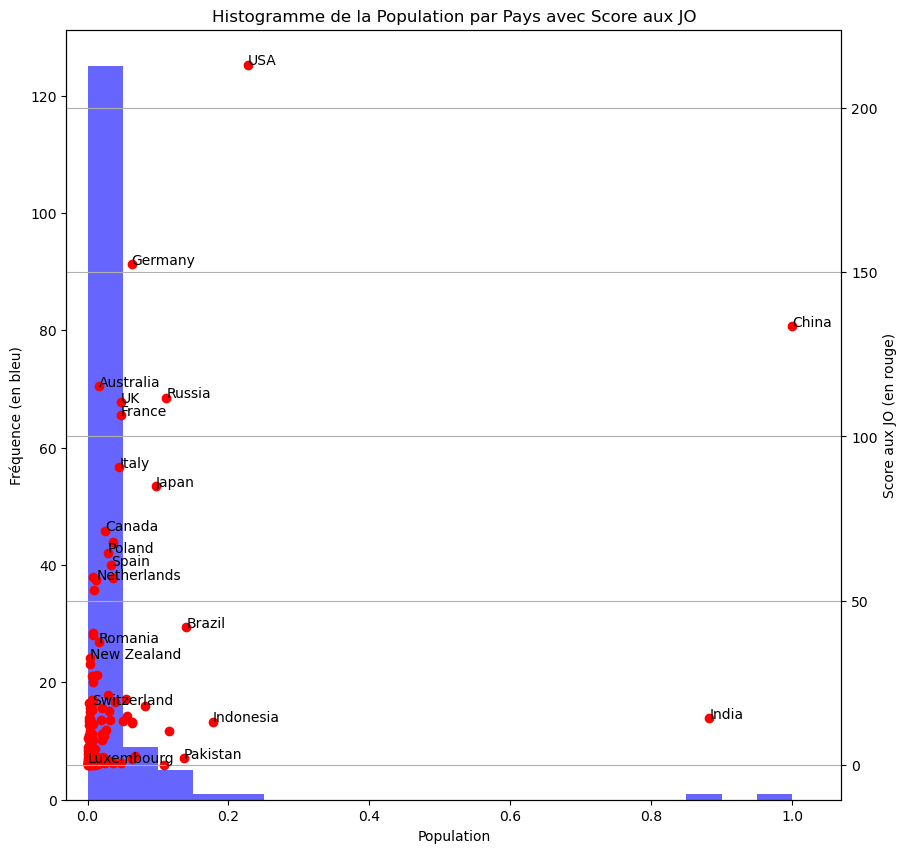

China


In [163]:
fig, ax1 = plt.subplots(figsize=(10, 10))

feature = 'pop'
xlabel  = 'Population'

# Histogramme
ax1.hist(df_mean_by_country[feature], bins=20, alpha=0.6, color='b')
ax1.set_xlabel(xlabel)
ax1.set_ylabel('Fréquence (en bleu)')
ax1.tick_params(axis='y')

# Axe y secondaire pour le score
ax2 = ax1.twinx()
ax2.scatter(df_mean_by_country[feature], df_mean_by_country['score'], color='r')
ax2.set_ylabel('Score aux JO (en rouge)')
ax2.tick_params(axis='y')

# Fonction pour vérifier la distance entre les points
def is_far_enough(x, y, points, min_distance):
    for (px, py) in points:
        if ((x - px)**2 + (y - py)**2)**0.5 < min_distance:
            return False
    return True

# Ajouter des labels pour certains pays
min_distance = 1  # A ajuster
labeled_points = []

for i in range(len(df_mean_by_country)):
    country = df_mean_by_country['country'][i]
    if country in country_to_display:
        if country == 'Great Britain':
            country = 'UK'
        x = df_mean_by_country[feature][i]
        y = df_mean_by_country['score'][i]
        if is_far_enough(x, y, labeled_points, min_distance):
            ax2.text(x, y, country)
            labeled_points.append((x, y))

plt.title('Histogramme de la Population par Pays avec Score aux JO')
plt.grid(True)
plt.xlim(-0.03, 1.07)
plt.show()

print(df_mean_by_country['country'][df_mean_by_country[feature].idxmax()])

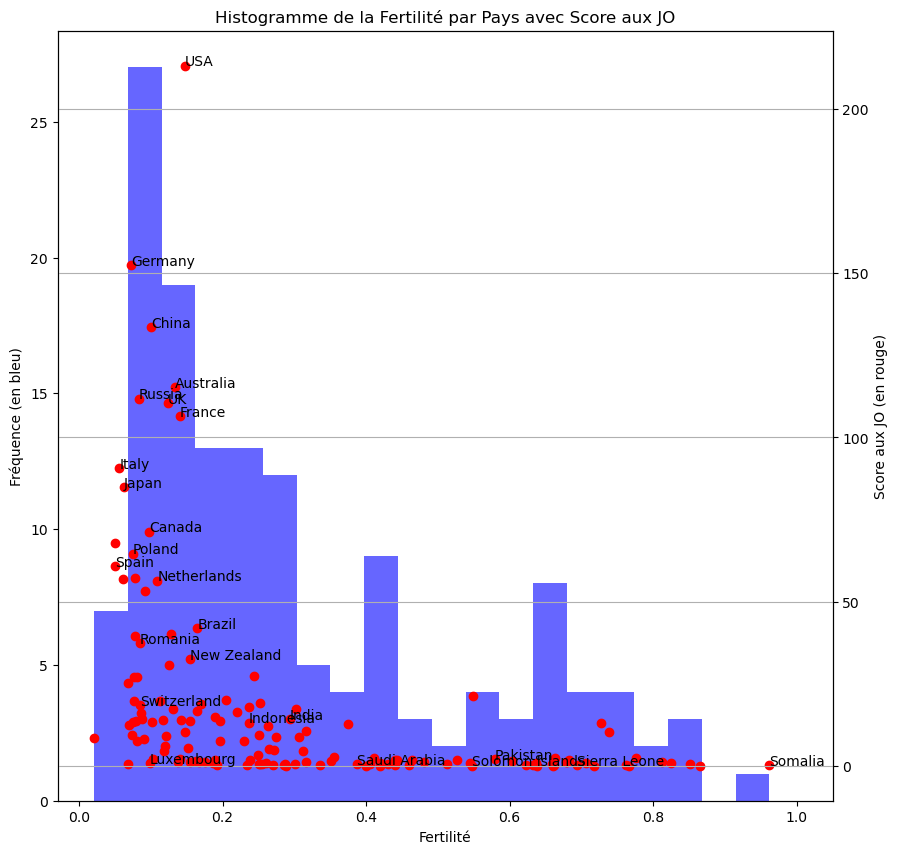

Somalia


In [164]:
fig, ax1 = plt.subplots(figsize=(10, 10))

feature = 'fertility'

# Histogramme
ax1.hist(df_mean_by_country[feature], bins=20, alpha=0.6, color='b')
ax1.set_xlabel('Fertilité')
ax1.set_ylabel('Fréquence (en bleu)')
ax1.tick_params(axis='y')

# Axe y secondaire pour le score
ax2 = ax1.twinx()
ax2.scatter(df_mean_by_country[feature], df_mean_by_country['score'], color='r')
ax2.set_ylabel('Score aux JO (en rouge)')
ax2.tick_params(axis='y')

# Fonction pour vérifier la distance entre les points
def is_far_enough(x, y, points, min_distance):
    for (px, py) in points:
        if ((x - px)**2 + (y - py)**2)**0.5 < min_distance:
            return False
    return True

# Ajouter des labels pour certains pays
min_distance = 0  # A ajuster
labeled_points = []

for i in range(len(df_mean_by_country)):
    country = df_mean_by_country['country'][i]
    if country in country_to_display:
        if country == 'Great Britain':
            country = 'UK'
        x = df_mean_by_country[feature][i]
        y = df_mean_by_country['score'][i]
        if is_far_enough(x, y, labeled_points, min_distance):
            ax2.text(x, y, country)
            labeled_points.append((x, y))

plt.title('Histogramme de la Fertilité par Pays avec Score aux JO')
plt.grid(True)
plt.xlim(-0.03, 1.05)
plt.show()

print(df_mean_by_country['country'][df_mean_by_country[feature].idxmax()])

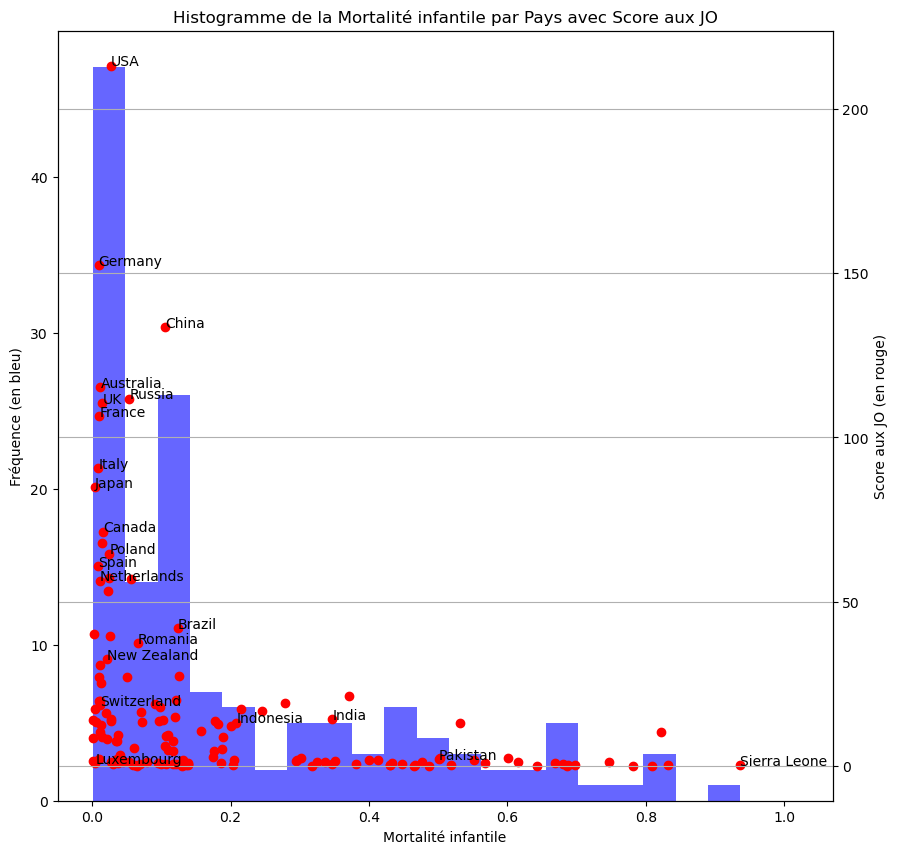

Sierra Leone


In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 10))

feature = 'child'
xlabel  = 'Mortalité infantile'

# Histogramme
ax1.hist(df_mean_by_country[feature], bins=20, alpha=0.6, color='b')
ax1.set_xlabel(xlabel)
ax1.set_ylabel('Fréquence (en bleu)')
ax1.tick_params(axis='y')

# Axe y secondaire pour le score
ax2 = ax1.twinx()
ax2.scatter(df_mean_by_country[feature], df_mean_by_country['score'], color='r')
ax2.set_ylabel('Score aux JO (en rouge)')
ax2.tick_params(axis='y')

# Fonction pour vérifier la distance entre les points
def is_far_enough(x, y, points, min_distance):
    for (px, py) in points:
        if ((x - px)**2 + (y - py)**2)**0.5 < min_distance:
            return False
    return True

# Ajouter des labels pour certains pays
min_distance = 1  # A ajuster
labeled_points = []

for i in range(len(df_mean_by_country)):
    country = df_mean_by_country['country'][i]
    if country in country_to_display:
        if country == 'Great Britain':
            country = 'UK'
        x = df_mean_by_country[feature][i]
        y = df_mean_by_country['score'][i]
        if is_far_enough(x, y, labeled_points, min_distance):
            ax2.text(x, y, country)
            labeled_points.append((x, y))

plt.title('Histogramme de la Mortalité infantile par Pays avec Score aux JO')
plt.grid(True)
plt.xlim(-0.05, 1.07)
plt.show()

print(df_mean_by_country['country'][df_mean_by_country[feature].idxmax()])

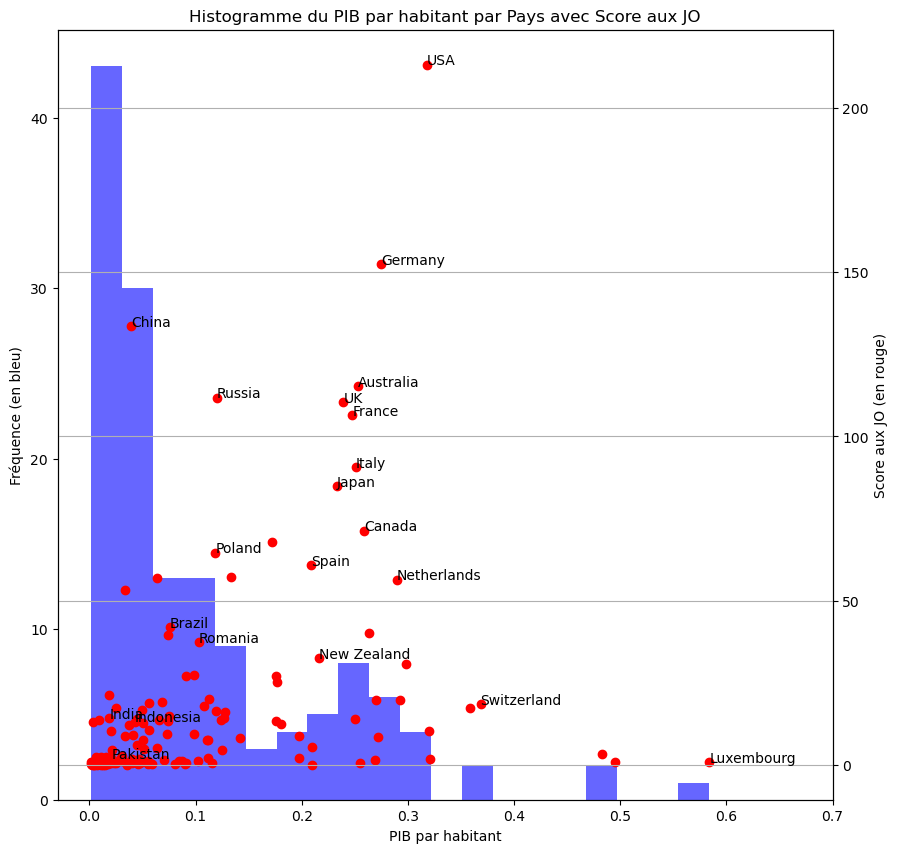

Luxembourg


In [134]:
fig, ax1 = plt.subplots(figsize=(10, 10))

feature = 'gdp'
xlabel  = 'PIB par habitant'

# Histogramme
ax1.hist(df_mean_by_country[feature], bins=20, alpha=0.6, color='b')
ax1.set_xlabel(xlabel)
ax1.set_ylabel('Fréquence (en bleu)')
ax1.tick_params(axis='y')

# Axe y secondaire pour le score
ax2 = ax1.twinx()
ax2.scatter(df_mean_by_country[feature], df_mean_by_country['score'], color='r')
ax2.set_ylabel('Score aux JO (en rouge)')
ax2.tick_params(axis='y')

# Fonction pour vérifier la distance entre les points
def is_far_enough(x, y, points, min_distance):
    for (px, py) in points:
        if ((x - px)**2 + (y - py)**2)**0.5 < min_distance:
            return False
    return True

# Ajouter des labels pour certains pays
min_distance = 1  # A ajuster
labeled_points = []

for i in range(len(df_mean_by_country)):
    country = df_mean_by_country['country'][i]
    if country in country_to_display:
        if country == 'Great Britain':
            country = 'UK'
        x = df_mean_by_country[feature][i]
        y = df_mean_by_country['score'][i]
        if is_far_enough(x, y, labeled_points, min_distance):
            ax2.text(x, y, country)
            labeled_points.append((x, y))

plt.title('Histogramme du PIB par habitant par Pays avec Score aux JO')
plt.grid(True)
plt.xlim(-0.03, 0.7)
plt.show()

print(df_mean_by_country['country'][df_mean_by_country[feature].idxmax()])

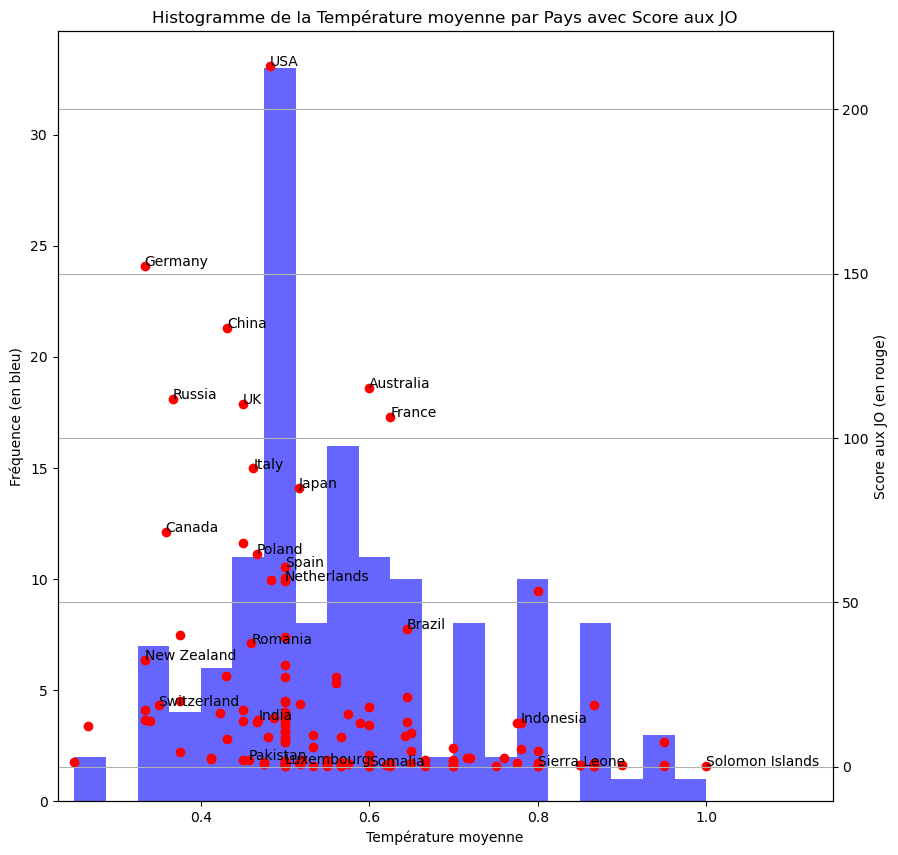

Solomon Islands


In [141]:
fig, ax1 = plt.subplots(figsize=(10, 10))

feature = 'Avg_Temperature'
xlabel  = 'Température moyenne'

# Histogramme
ax1.hist(df_mean_by_country[feature], bins=20, alpha=0.6, color='b')
ax1.set_xlabel(xlabel)
ax1.set_ylabel('Fréquence (en bleu)')
ax1.tick_params(axis='y')

# Axe y secondaire pour le score
ax2 = ax1.twinx()
ax2.scatter(df_mean_by_country[feature], df_mean_by_country['score'], color='r')
ax2.set_ylabel('Score aux JO (en rouge)')
ax2.tick_params(axis='y')

# Fonction pour vérifier la distance entre les points
def is_far_enough(x, y, points, min_distance):
    for (px, py) in points:
        if ((x - px)**2 + (y - py)**2)**0.5 < min_distance:
            return False
    return True

# Ajouter des labels pour certains pays
min_distance = 0  # A ajuster
labeled_points = []

for i in range(len(df_mean_by_country)):
    country = df_mean_by_country['country'][i]
    if country in country_to_display:
        if country == 'Great Britain':
            country = 'UK'
        x = df_mean_by_country[feature][i]
        y = df_mean_by_country['score'][i]
        if is_far_enough(x, y, labeled_points, min_distance):
            ax2.text(x, y, country)
            labeled_points.append((x, y))

plt.title('Histogramme de la Température moyenne par Pays avec Score aux JO')
plt.grid(True)
plt.xlim(0.23, 1.15)
plt.show()

print(df_mean_by_country['country'][df_mean_by_country[feature].idxmax()])

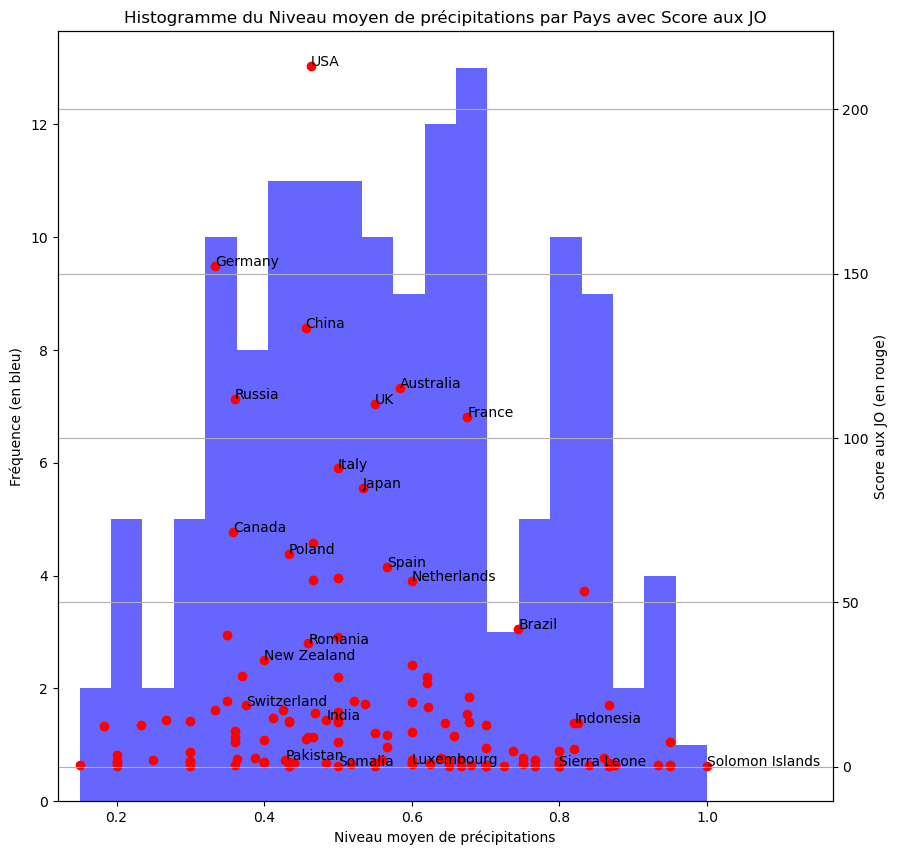

Solomon Islands


In [146]:
fig, ax1 = plt.subplots(figsize=(10, 10))

feature = 'Avg_Precipitation'
xlabel  = 'Niveau moyen de précipitations'

# Histogramme
ax1.hist(df_mean_by_country[feature], bins=20, alpha=0.6, color='b')
ax1.set_xlabel(xlabel)
ax1.set_ylabel('Fréquence (en bleu)')
ax1.tick_params(axis='y')

# Axe y secondaire pour le score
ax2 = ax1.twinx()
ax2.scatter(df_mean_by_country[feature], df_mean_by_country['score'], color='r')
ax2.set_ylabel('Score aux JO (en rouge)')
ax2.tick_params(axis='y')

# Fonction pour vérifier la distance entre les points
def is_far_enough(x, y, points, min_distance):
    for (px, py) in points:
        if ((x - px)**2 + (y - py)**2)**0.5 < min_distance:
            return False
    return True

# Ajouter des labels pour certains pays
min_distance = 0  # A ajuster
labeled_points = []

for i in range(len(df_mean_by_country)):
    country = df_mean_by_country['country'][i]
    if country in country_to_display:
        if country == 'Great Britain':
            country = 'UK'
        x = df_mean_by_country[feature][i]
        y = df_mean_by_country['score'][i]
        if is_far_enough(x, y, labeled_points, min_distance):
            ax2.text(x, y, country)
            labeled_points.append((x, y))

plt.title('Histogramme du Niveau moyen de précipitations par Pays avec Score aux JO')
plt.grid(True)
plt.xlim(0.12, 1.17)
plt.show()

print(df_mean_by_country['country'][df_mean_by_country[feature].idxmax()])

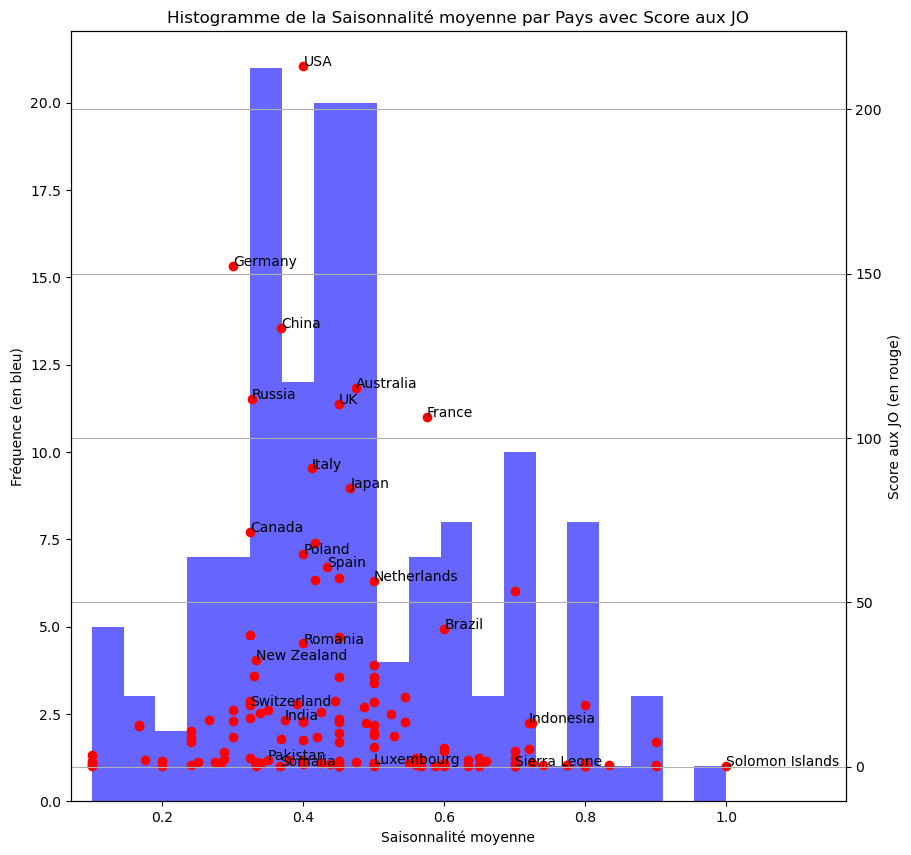

Solomon Islands


In [151]:
fig, ax1 = plt.subplots(figsize=(10, 10))

feature = 'Avg_Seasonality'
xlabel  = 'Saisonnalité moyenne'

# Histogramme
ax1.hist(df_mean_by_country[feature], bins=20, alpha=0.6, color='b')
ax1.set_xlabel(xlabel)
ax1.set_ylabel('Fréquence (en bleu)')
ax1.tick_params(axis='y')

# Axe y secondaire pour le score
ax2 = ax1.twinx()
ax2.scatter(df_mean_by_country[feature], df_mean_by_country['score'], color='r')
ax2.set_ylabel('Score aux JO (en rouge)')
ax2.tick_params(axis='y')

# Fonction pour vérifier la distance entre les points
def is_far_enough(x, y, points, min_distance):
    for (px, py) in points:
        if ((x - px)**2 + (y - py)**2)**0.5 < min_distance:
            return False
    return True

# Ajouter des labels pour certains pays
min_distance = 0  # A ajuster
labeled_points = []

for i in range(len(df_mean_by_country)):
    country = df_mean_by_country['country'][i]
    if country in country_to_display:
        if country == 'Great Britain':
            country = 'UK'
        x = df_mean_by_country[feature][i]
        y = df_mean_by_country['score'][i]
        if is_far_enough(x, y, labeled_points, min_distance):
            ax2.text(x, y, country)
            labeled_points.append((x, y))

plt.title('Histogramme de la Saisonnalité moyenne par Pays avec Score aux JO')
plt.grid(True)
plt.xlim(0.07, 1.17)
plt.show()

print(df_mean_by_country['country'][df_mean_by_country[feature].idxmax()])

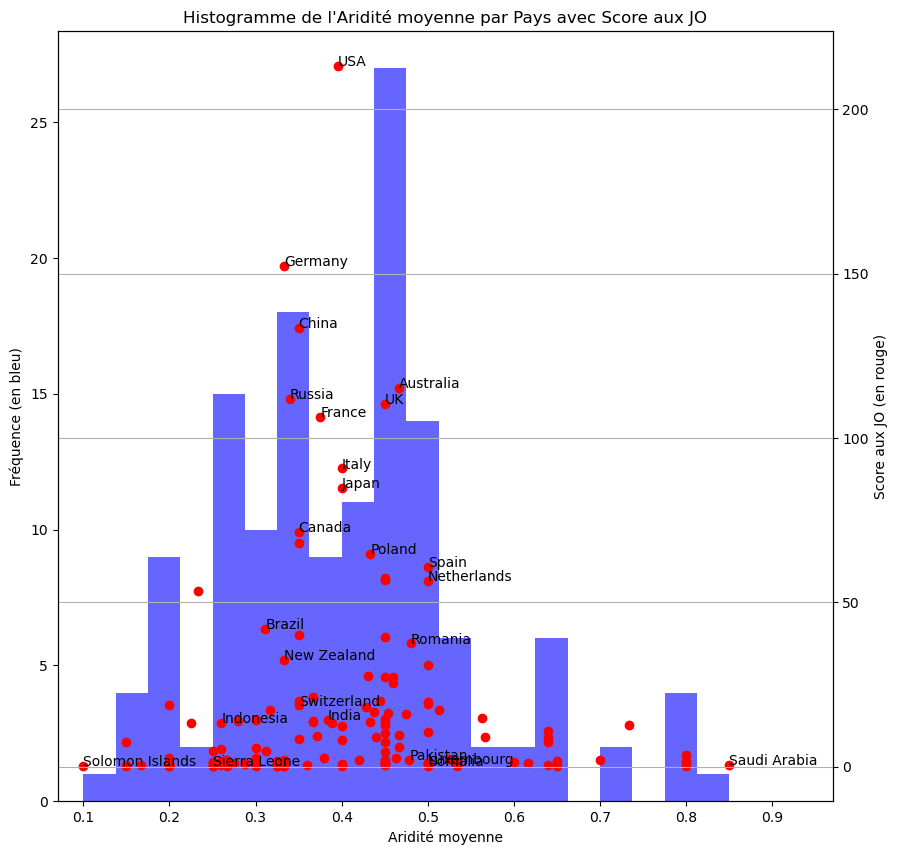

Saudi Arabia


In [160]:
fig, ax1 = plt.subplots(figsize=(10, 10))

feature = 'Avg_Aridity'
xlabel  = 'Aridité moyenne'

# Histogramme
ax1.hist(df_mean_by_country[feature], bins=20, alpha=0.6, color='b')
ax1.set_xlabel(xlabel)
ax1.set_ylabel('Fréquence (en bleu)')
ax1.tick_params(axis='y')

# Axe y secondaire pour le score
ax2 = ax1.twinx()
ax2.scatter(df_mean_by_country[feature], df_mean_by_country['score'], color='r')
ax2.set_ylabel('Score aux JO (en rouge)')
ax2.tick_params(axis='y')

# Fonction pour vérifier la distance entre les points
def is_far_enough(x, y, points, min_distance):
    for (px, py) in points:
        if ((x - px)**2 + (y - py)**2)**0.5 < min_distance:
            return False
    return True

# Ajouter des labels pour certains pays
min_distance = 0  # A ajuster
labeled_points = []

for i in range(len(df_mean_by_country)):
    country = df_mean_by_country['country'][i]
    if country in country_to_display:
        if country == 'Great Britain':
            country = 'UK'
        x = df_mean_by_country[feature][i]
        y = df_mean_by_country['score'][i]
        if is_far_enough(x, y, labeled_points, min_distance):
            ax2.text(x, y, country)
            labeled_points.append((x, y))

plt.title("Histogramme de l'Aridité moyenne par Pays avec Score aux JO")
plt.grid(True)
plt.xlim(0.07, 0.97)
plt.show()

print(df_mean_by_country['country'][df_mean_by_country[feature].idxmax()])

## F-Test

Le F-test pour la sélection de variables (feature selection) est une méthode statistique utilisée pour déterminer si des variables explicatives (features) sont significativement liées à la variable cible dans des tâches supervisées, notamment la régression ou la classification.

## Pour la régression

In [11]:
# Application du F-test pour la régression
f_scores_regression, p_values_regression = f_regression(X, y_regression)

# Création d'un DataFrame pour visualiser les scores et p-values
features = ['pop', 'fertility', 'child', 'gdp', 'Avg_Temperature', 'Avg_Precipitation', 'Avg_Seasonality', 'Avg_Aridity']
f_test_results_regression = pd.DataFrame({
    'Feature': features,
    'F-Score': f_scores_regression,
    'P-Value': p_values_regression,
})

# Trier par F-Score pour voir les plus significatives
f_test_results_regression = f_test_results_regression.sort_values(by='F-Score', ascending=False)
print("F-Test pour la Régression :")
print(f_test_results_regression)

F-Test pour la Régression :
             Feature     F-Score       P-Value
1          fertility  205.113741  6.563531e-43
0                pop  148.739592  3.004949e-32
3             capita  147.518403  5.177608e-32
2              child  142.810974  4.238449e-31
4    Avg_Temperature  106.669455  5.742112e-24
5  Avg_Precipitation   34.361138  5.984948e-09
6    Avg_Seasonality   17.662199  2.843989e-05
7        Avg_Aridity    0.093634  7.596623e-01


## Pour la classification

In [12]:
# Application du F-test pour la classification
f_scores_classification, p_values_classification = f_classif(X, y_classification)

# Création d'un DataFrame pour visualiser les scores et p-values
f_test_results_classification = pd.DataFrame({
    'Feature': features,
    'F-Score': f_scores_classification,
    'P-Value': p_values_classification
})

# Trier par F-Score pour voir les plus significatives
f_test_results_classification = f_test_results_classification.sort_values(by='F-Score', ascending=False)
print("\nF-Test pour la Classification :")
print(f_test_results_classification)


F-Test pour la Classification :
             Feature    F-Score       P-Value
1          fertility  80.086045  2.841133e-33
2              child  53.493904  6.215268e-23
3             capita  52.116829  2.192047e-22
0                pop  42.979266  1.009278e-18
4    Avg_Temperature  30.655487  1.076142e-13
5  Avg_Precipitation   9.208776  1.077987e-04
6    Avg_Seasonality   4.218362  1.495301e-02
7        Avg_Aridity   0.385406  6.802626e-01


## Mutual Information

L'information mutuelle (MI) est une mesure issue de la théorie de l'information qui quantifie la dépendance entre deux variables aléatoires. En feature selection (sélection de variables), l'information mutuelle permet d'évaluer combien une variable explicative 
𝑋
X réduit l'incertitude sur la variable cible 
𝑌
Y. Contrairement au F-test, l'information mutuelle détecte aussi bien les relations linéaires que non linéaires.

## Pour la régression

In [13]:
# Application de l'information mutuelle pour la régression
mi_scores_regression = mutual_info_regression(X, y_regression)

# Création d'un DataFrame pour visualiser les scores MI
mi_results_regression = pd.DataFrame({
    'Feature': features,
    'MI-Score': mi_scores_regression
})

# Trier par MI-Score pour voir les plus informatives
mi_results_regression = mi_results_regression.sort_values(by='MI-Score', ascending=False)
print("Information Mutuelle pour la Régression :")
print(mi_results_regression)

Information Mutuelle pour la Régression :
             Feature  MI-Score
4    Avg_Temperature  0.418123
6    Avg_Seasonality  0.397034
5  Avg_Precipitation  0.377275
7        Avg_Aridity  0.373886
1          fertility  0.325647
0                pop  0.294987
2              child  0.287947
3             capita  0.242650


## Pour la classification

In [14]:
# Application de l'information mutuelle pour la classification
mi_scores_classification = mutual_info_classif(X, y_classification)

# Création d'un DataFrame pour visualiser les scores MI
mi_results_classification = pd.DataFrame({
    'Feature': features,
    'MI-Score': mi_scores_classification
})

# Trier par MI-Score pour voir les plus informatives
mi_results_classification = mi_results_classification.sort_values(by='MI-Score', ascending=False)
print("\nInformation Mutuelle pour la Classification :")
print(mi_results_classification)



Information Mutuelle pour la Classification :
             Feature  MI-Score
5  Avg_Precipitation  0.200327
6    Avg_Seasonality  0.192193
4    Avg_Temperature  0.180176
0                pop  0.179098
7        Avg_Aridity  0.167591
1          fertility  0.127430
2              child  0.126643
3             capita  0.113089


## Comparaison

In [15]:
# Comparaison pour la régression
comparison_regression = pd.merge(f_test_results_regression, mi_results_regression, on='Feature')
print("\nComparaison F-Score et MI-Score (Régression) :")
print(comparison_regression)

# Comparaison pour la classification
comparison_classification = pd.merge(f_test_results_classification, mi_results_classification, on='Feature')
print("\nComparaison F-Score et MI-Score (Classification) :")
print(comparison_classification)



Comparaison F-Score et MI-Score (Régression) :
             Feature     F-Score       P-Value  MI-Score
0          fertility  205.113741  6.563531e-43  0.325647
1                pop  148.739592  3.004949e-32  0.294987
2             capita  147.518403  5.177608e-32  0.242650
3              child  142.810974  4.238449e-31  0.287947
4    Avg_Temperature  106.669455  5.742112e-24  0.418123
5  Avg_Precipitation   34.361138  5.984948e-09  0.377275
6    Avg_Seasonality   17.662199  2.843989e-05  0.397034
7        Avg_Aridity    0.093634  7.596623e-01  0.373886

Comparaison F-Score et MI-Score (Classification) :
             Feature    F-Score       P-Value  MI-Score
0          fertility  80.086045  2.841133e-33  0.127430
1              child  53.493904  6.215268e-23  0.126643
2             capita  52.116829  2.192047e-22  0.113089
3                pop  42.979266  1.009278e-18  0.179098
4    Avg_Temperature  30.655487  1.076142e-13  0.180176
5  Avg_Precipitation   9.208776  1.077987e-04  0.20

### Explication des scores :
**F-Score :** mesure la relation linéaire entre les variables explicatives et la cible.

**MI-Score :** mesure la dépendance (linéaire et non linéaire) entre les variables explicatives et la cible.

### **Analyse des résultats :**

Voici une analyse des résultats pour la **régression** et la **classification**.

---

### **1. Régression :**

| **Feature**        | **F-Score** | **MI-Score** | **Interprétation**                                   |
|--------------------|-------------|-------------|-----------------------------------------------------|
| **fertility**       | 205.11      | 0.33        | Très significative avec un bon MI-score.             |
| **pop**             | 148.74      | 0.29        | Forte relation linéaire et non linéaire.             |
| **gdp**             | 147.52      | 0.24        | Significative mais légèrement plus faible en MI.     |
| **child**           | 142.81      | 0.29        | Indique une corrélation importante et non linéaire.  |
| **Avg_Temperature** | 106.67      | 0.42        | Relation non linéaire forte : le MI-score est élevé. |
| **Avg_Precipitation** | 34.36     | 0.38        | Relation moins linéaire, mais significative en MI.   |
| **Avg_Seasonality** | 17.66       | 0.40        | Relation non linéaire claire malgré un faible F-Score. |
| **Avg_Aridity**     | 0.09        | 0.37        | Le F-test la juge insignifiante, mais MI montre une contribution. |

#### **Observation globale :**
- Les variables comme **Avg_Temperature**, **Avg_Seasonality**, et **Avg_Aridity** ont des **F-Scores faibles** mais des **MI-Scores élevés**, indiquant des **relations non linéaires** avec la variable cible.
- La variable **fertility** est significative dans les deux méthodes.

---

### **2. Classification :**

| **Feature**        | **F-Score** | **MI-Score** | **Interprétation**                                   |
|--------------------|-------------|-------------|-----------------------------------------------------|
| **fertility**       | 80.09       | 0.13        | Très significative linéaire, mais MI-score modéré.   |
| **child**           | 53.49       | 0.13        | Bonne dépendance linéaire et non linéaire.           |
| **gdp**             | 52.11       | 0.11        | Significative dans les deux cas, mais faible en MI.  |
| **pop**             | 42.98       | 0.18        | Contribution plus forte en MI qu’en F-score.         |
| **Avg_Temperature** | 30.66       | 0.18        | Relation non linéaire, reflétée dans un MI-score plus élevé. |
| **Avg_Precipitation** | 9.20      | 0.20        | Peu linéaire (F-score faible) mais forte dépendance globale. |
| **Avg_Seasonality** | 4.21        | 0.19        | Contribution principalement non linéaire.            |
| **Avg_Aridity**     | 0.39        | 0.17        | Le F-score est insignifiant, mais MI montre une relation. |

#### **Observation globale :**
- Les variables comme **Avg_Temperature**, **Avg_Precipitation**, et **Avg_Seasonality** sont clairement **non linéaires** dans leur relation avec la classe des médailles.
- La variable **fertility** reste une variable-clé dans les deux cas.

---

### **Comparaison globale F-Test vs Information Mutuelle :**

| **Points clés**     | **F-Test**                             | **Information Mutuelle**                    |
|--------------------|----------------------------------------|---------------------------------------------|
| **Type de relation**| Détecte uniquement les relations linéaires. | Détecte les relations linéaires et non linéaires. |
| **Variables influentes** | Forte influence de **fertility**, **capita** | Influence non linéaire des variables climatiques. |
| **Faibles contributeurs** | **Avg_Aridity** ignorée par le F-test. | **Avg_Aridity** montre une contribution modérée. |

---

### **Recommandation :**
- Inclure **Avg_Temperature**, **Avg_Precipitation**, et **Avg_Seasonality** dans le modèle, car elles présentent des **dépendances non linéaires** avec la cible.
- Nous pouvons ignorer les variables avec un **MI-Score très faible** (< 0.1).

---

Ces résultats montrent l'intérêt de combiner plusieurs approches de sélection pour capturer à la fois les relations linéaires et non linéaires des données.

